# Goal

Viz contour loss (perimeter based)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Data Augs
from transforms import AddChannel, Iso, PadSz


# Helper functions
from helpers.losses      import contour3d, contour3d_loss
from helpers.preprocess  import get_data_dict_n4, mask2bbox, print_bbox
from helpers.general     import sitk2np, np2sitk, print_sitk_info, lrange
from helpers.viz_contour import plot3d, plot2d, process3d

# Utilities
import os, sys, time, pickle, re
from pathlib import Path

# Input IO
import SimpleITK as sitk
import torch
import numpy as np

# Fastai
from fastai import *
from fastai.basics import *

# Get data (filenames)

In [3]:
from helpers.items_constants import (
    data_src, label_src, dsetmd_src,
    all_lbl_items
)

Full lbl items: 335
Removed 2 weird, new total lbl items: 333
train, valid, test 201 66 66 total 333
Cross label items:  418
All label items:  751 (abide (333) + cross_lbl (418))
Test label items:  484 (test (66) + cross_lbl (418))


# Get items (tensors)

In [4]:
iso_sz = 2
maxs   = [144, 144, 144]

# no subset
item_subset = all_lbl_items

item_tfms  = [Iso(iso_sz), PadSz(maxs)]
tls        = TfmdLists(item_subset, item_tfms)

In [5]:
tdl = TfmdDL(all_lbl_items, after_item=item_tfms, after_batch=[], bs=20)

In [6]:
start = time.time()
batch = tdl.one_batch()
elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f} s.")

Elapsed: 6.25 s.


# Isoperimetric ratio

In [12]:
torch.max(
    torch.tensor([[0.9,0,0.7],[0.9,0,0.7]]), 
    torch.tensor([[0,0,0.5],[0,0,0.5]]), 
    torch.tensor([[0,0.6,0.2],[0,0.6,0.3]])
)

TypeError: max() received an invalid combination of arguments - got (Tensor, Tensor, Tensor), but expected one of:
 * (Tensor input)
 * (Tensor input, name dim, bool keepdim, *, tuple of Tensors out)
 * (Tensor input, Tensor other, *, Tensor out)
 * (Tensor input, int dim, bool keepdim, *, tuple of Tensors out)


In [17]:
import torch.nn.functional as F

# BCDHW -> BDHW -> B x (vols)
def get_vol(mk):                return mk.sum(dim=-3).sum(dim=-2).sum(dim=-1).squeeze()

def get_contour(mk, dim=3):
    # dim kernel
    kernel   = tuple(3 for _ in range(dim))
    max_pool = [0, F.max_pool1d, F.max_pool2d, F.max_pool3d][dim]
   
    # BCDHW
    min_pool_x1     = max_pool(mk.float()*-1, kernel, 1, 1)*-1
    max_min_pool_x1 = max_pool(min_pool_x1,   kernel, 1, 1)
    contour         = torch.nn.functional.relu(max_min_pool_x1 - min_pool_x1)
    
    return contour

def get_contour_vol(mk, dim=3): 
    contour = get_contour(mk, dim=dim)
    return contour, get_vol(contour)

def get_sa(mk):
    # pad to ensure no boundary issue w. contour
    mk = F.pad(mk, (1,1,1,1,1,1), "constant", 0)

    # 3d: BCDHW
    three, three_vol = get_contour_vol(mk, dim=3)
   
    # 2d: BCDHW => B(D)HW, B(H)DW, B(W)DH (channel dim = D,H,W)
    pre2d = three.squeeze(1)
    two0 = get_contour(pre2d, dim=2)
    two1 = get_contour(torch.transpose(pre2d,1,2), dim=2)
    two2 = get_contour(torch.transpose(pre2d,1,3).transpose(2,3), dim=2)

    # combine to common BCDHW and then (or them together: two0 V two1 V two2)
    two = torch.max(two0.unsqueeze(1),
                    torch.max(
                        two1.transpose(1,2).unsqueeze(1),
                        two2.transpose(2,3).transpose(1,3).unsqueeze(1)
                    )
    )
    
    idxs = two>1
    a = two0.unsqueeze(1)[idxs]
    b = two1.transpose(1,2).unsqueeze(1)[idxs]
    c = two2.transpose(2,3).transpose(1,3).unsqueeze(1)[idxs]
    assert(torch.equal(a,b))
    assert(torch.equal(a,c))
    assert(torch.equal(b,c))
    #two[two>1] = 1  #removes double counting
    two_vol = get_vol(two)

    
    # 1d: B(D)HW => (BD)HW (batch*depth = batch dim, height = channel dim)
    B,D,H,W = two0.shape
    pre1d = two0.reshape(B*D,H,W)
    one = get_contour(pre1d, dim=1).reshape(B,D,H,W)
    one_vol = get_vol(one)
    
    return three_vol + two_vol + one_vol

# sphere = 1
def get_vol_sa_ratio(vol, surfacearea): return 36 * np.pi * (vol**2/surfacearea**3)
def get_iso_ratio(mk): return get_vol_sa_ratio(get_vol(mk), get_sa(mk))

In [18]:
# test batch

# square, of size 2x5x5, elevated by 0
x,y,z = 5,5,3
start_x, start_y, start_z = 2,2,2
mk0 = torch.zeros((50,50,50))
mk0[start_x:start_x+x, start_y:start_y+y, start_z:start_z+z] = 1
print(mk0[2,0:10,0:10])
# rectangular prism, of size 3x2x3
x,y,z = 3,4,3
start_x, start_y, start_z = 10,10,10
mk1 = torch.zeros((50,50,50))
mk1[start_x:start_x+x, start_y:start_y+y, start_z:start_z+z] = 1

b = torch.stack([mk0, mk1], dim=0).unsqueeze(1)
print("shapes: ", b.shape, mk0.unsqueeze(0).unsqueeze(0).shape, mk1.unsqueeze(0).unsqueeze(0).shape)
print(get_sa(mk0.unsqueeze(0).unsqueeze(0)))
print(get_sa(mk1.unsqueeze(0).unsqueeze(0)))
print(get_sa(b))

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
shapes:  torch.Size([2, 1, 50, 50, 50]) torch.Size([1, 1, 50, 50, 50]) torch.Size([1, 1, 50, 50, 50])
tensor(110.)
tensor(66.)
tensor([110.,  66.])


In [141]:
batch = tdl.one_batch()

In [118]:
ratios = get_iso_ratio(batch[1])

In [121]:
ratios

tensor([0.4718, 0.4332, 0.4261, 0.3741, 0.3949, 0.3618, 0.4144, 0.4199, 0.4865,
        0.4131, 0.4848, 0.4457, 0.3870, 0.3990, 0.3907, 0.3594, 0.3799, 0.3172,
        0.3946, 0.3886])

In [ ]:
print(batch[0].shape)

In [142]:
r = []

for batch in tdl:
    yb = batch[1].unsqueeze(1)
    print(yb.shape)
    r += get_iso_ratio(yb)

torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 144, 144, 144])
torch.Size([20, 1, 1

In [103]:
def test(x,y,z):
    mk = torch.zeros((50,50,50))
    mk[2:2+x, 2:2+y, 2:2+z] = 1
    mk = mk.unsqueeze(0).unsqueeze(0)
    gt_vol = x*y*z
    gt_sa = 2*(x*y+x*z+y*z)

    # 3d: BCDHW
    est_sa3d, est_sa3d_vol = get_contour_vol(mk, dim=3)
    #print("3d", est_sa3d.shape)
    #print("pre 3d", est_sa3d.shape)
    
    # 2d: BCDHW => B(D)HW, B(H)DW, B(W)DH (channel dim = D,H,W)
    pre2d = est_sa3d.squeeze(1)
    est_sa2d_axis0, est_sa2d_vol_axis0 = get_contour_vol(pre2d, dim=2)
    est_sa2d_axis1, est_sa2d_vol_axis1 = get_contour_vol(torch.transpose(pre2d,1,2), dim=2)
    est_sa2d_axis2, est_sa2d_vol_axis2 = get_contour_vol(torch.transpose(pre2d,1,3).transpose(2,3), dim=2)

    # combine to common BCDHW and then (or them together: two0 V two1 V two2)
    two0 = est_sa2d_axis0.unsqueeze(1)
    two1 = est_sa2d_axis1.transpose(1,2).unsqueeze(1)
    two2 = est_sa2d_axis2.transpose(2,3).transpose(1,3).unsqueeze(1)
    est_sa2d = two0 + two1 + two2
    est_sa2d[est_sa2d>1] = 1  #removes double counting
    est_sa2d_vol = get_vol(est_sa2d)

    # 1d: DHW (depth = batch dim, height = channel dim)
    pre1d = est_sa2d_axis0.squeeze(0)
    est_sa1d_axis0, est_sa1d_vol_axis0 = get_contour_vol(pre1d, dim=1)
#     est_sa1d_axis1, est_sa1d_vol_axis1 = get_contour(torch.transpose(pre1d, 0,1), dim=1)
#     est_sa1d_axis2, est_sa1d_vol_axis2 = get_contour(torch.transpose(pre1d, 0,2).transpose(1,2), dim=1)
    
    #print("1d", est_sa1d.shape)
    print(x,y,z)
    three    = est_sa3d_vol 
    two      = est_sa2d_vol
    one      = est_sa1d_vol_axis0
    full_sum = three + two + one
    diff =  full_sum - gt_sa
    print(three, two, one, full_sum, gt_sa); print(diff); print("*"*50)
    
#     two1,two2,two3 = est_sa2d_vol_axis0, est_sa2d_vol_axis1, est_sa2d_vol_axis2 
#     one1,one2,one3 = est_sa1d_vol_axis0, est_sa1d_vol_axis1, est_sa1d_vol_axis2 
#     full_sum = three + two1 + two2 + two3 #- one1 - one2 - one3
#     diff =  full_sum - gt_sa
    
#    print(three,two1,two2,two3,one1,one2,one3,full_sum, gt_sa); print(diff); print("*"*50)
    
    #est_sa3d_vol + est_sa2d_vol + est_sa1d_vol, gt_sa)
    #print(gt_sa - (est_sa3d_vol + est_sa2d_vol + est_sa1d_vol)); print("*"*50)
    #diff =  est_sa - gt_sa
    
    #return mk, est_sa3d, est_sa2d, est_sa1d
            

In [104]:
# def test(x,y,z):
#     mk = torch.zeros((50,50,50))
#     mk[2:2+x, 2:2+y, 2:2+z] = 1
#     mk = mk.unsqueeze(0).unsqueeze(0)
#     gt_vol = x*y*z
#     gt_sa = 2*(x*y+x*z+y*z)

#     # 3d: BCDHW
#     est_sa3d, est_sa3d_vol = get_contour(mk, dim=3)
#     #print("3d", est_sa3d.shape)
#     #print("pre 3d", est_sa3d.shape)
    
#     # 2d: BCDHW (depth becomes channel dim). DHW, HDW, 
#     pre2d = est_sa3d.squeeze(1)
#     est_sa2d_axis0, est_sa2d_vol_axis0 = get_contour(pre2d, dim=2)
#     est_sa2d_axis1, est_sa2d_vol_axis1 = get_contour(torch.transpose(pre2d,1,2), dim=2)
#     est_sa2d_axis2, est_sa2d_vol_axis2 = get_contour(torch.transpose(pre2d,1,3).transpose(2,3), dim=2)

#     # combine
#     est_sa2d = 

#     # 1d: DHW (depth = batch dim, height = channel dim)
#     pre1d = est_sa2d_axis0.squeeze(0)
#     est_sa1d_axis0, est_sa1d_vol_axis0 = get_contour(pre1d, dim=1)
#     est_sa1d_axis1, est_sa1d_vol_axis1 = get_contour(torch.transpose(pre1d, 0,1), dim=1)
#     est_sa1d_axis2, est_sa1d_vol_axis2 = get_contour(torch.transpose(pre1d, 0,2).transpose(1,2), dim=1)
    
#     #print("1d", est_sa1d.shape)
#     print(x,y,z)
#     three = est_sa3d_vol 
#     two1,two2,two3 = est_sa2d_vol_axis0, est_sa2d_vol_axis1, est_sa2d_vol_axis2 
#     one1,one2,one3 = est_sa1d_vol_axis0, est_sa1d_vol_axis1, est_sa1d_vol_axis2 
#     full_sum = three + two1 + two2 + two3 #- one1 - one2 - one3
#     diff =  full_sum - gt_sa
    
#     print(three,two1,two2,two3,one1,one2,one3,full_sum, gt_sa); print(diff); print("*"*50)
    
#     #est_sa3d_vol + est_sa2d_vol + est_sa1d_vol, gt_sa)
#     #print(gt_sa - (est_sa3d_vol + est_sa2d_vol + est_sa1d_vol)); print("*"*50)
#     #diff =  est_sa - gt_sa
    
#     return mk, est_sa3d, est_sa2d, est_sa1d
            

In [ ]:
start = 0
mk = torch.zeros((50,50,50))

# square, of size 2x5x5, elevated by 0
start_x, start_y, start_z = 0,0,0
x,y,z = 5,5,2
mk[start_x:start_x+x, start_y:start_y+y, start_z:start_z+z] = 1

# rectangular prism, of size 3x2x3
start_x, start_y, start_z = 0,0,0
x,y,z = 3,2,3
mk[start_x:start_x+x, start_y:start_y+y, start_z:start_z+z] = 1

gt_sa = 

In [106]:
for x in range(3,8):
    for y in range(4,8):
        for z in range(5,10):
#               test(x,y,z)
            start = 0
            mk = torch.zeros((50,50,50))
            mk[start:start+x, start:start+y, start:start+z] = 1
            #mk[start:start+x, start:start+y, start:start+z] = 1
            mk = mk.unsqueeze(0).unsqueeze(0)
            gt_vol = x*y*z
            gt_sa = 2*(x*y+x*z+y*z)
            assert (get_sa(mk) - gt_sa) == torch.tensor(0)


In [8]:
# BCDHW -> BDHW -> B x (vols)
def get_vol(mk):
    return mk.squeeze(1).sum(dim=3).sum(dim=2).sum(dim=1)

# estimate contour DILATION (max pool) - EROSION (min pool of max pool)
def get_vol_sa(mk):
    # BCDHW
    min_pool_x1     = torch.nn.functional.max_pool3d(mk.float()*-1, (3, 3, 3), 1, 1)*-1
    max_min_pool_x1 = torch.nn.functional.max_pool3d(min_pool_x1, (3, 3, 3), 1, 1)
    contour         = torch.nn.functional.relu(max_min_pool_x1 - min_pool_x1)
    return get_vol(mk), get_vol(contour)

# sphere = 1
def get_isoperimetric_ratio(vol, surfacearea): return 36 * np.pi * (vol**2/surfacearea**3)

In [119]:
diffs = []
diff_rats = []
for x in range(12,30):
    for y in range(12,30):
        for z in range(12,30):
            mk = torch.zeros((96,96,96))
            mk[2:2+x, 2:2+y, 2:2+z] = 1
            mk = mk.unsqueeze(0).unsqueeze(0)
            gt_sa = 2*(x*y+x*z+y*z)
            gt_vol, est_sa = get_vol_sa(mk)
            diff =  est_sa - gt_sa
            diff_rat = get_isoperimetric_ratio(gt_vol, gt_sa) - get_isoperimetric_ratio(gt_vol, est_sa) 
            #print("GT SA = ", 2*(x*y+x*z+y*z))
            #print("Calc SA = ", est_sa)
            #print("diff = ", est_sa - gt_sa)
            diffs.append(diff)
            diff_rats.append(diff_rat)

KeyboardInterrupt: 

In [120]:
%debug

> /usr/local/lib/python3.6/dist-packages/torch/nn/functional.py(629)_max_pool3d()
    627         stride = torch.jit.annotate(List[int], [])
    628     return torch.max_pool3d(
--> 629         input, kernel_size, stride, padding, dilation, ceil_mode)
    630 
    631 max_pool3d = boolean_dispatch(

ipdb> x
*** NameError: name 'x' is not defined
ipdb> up
> /usr/local/lib/python3.6/dist-packages/torch/_jit_internal.py(267)fn()
    265             return if_true(*args, **kwargs)
    266         else:
--> 267             return if_false(*args, **kwargs)
    268 
    269     if if_true.__doc__ is None and if_false.__doc__ is not None:

ipdb> up
> <ipython-input-7-f1fa2e620035>(9)get_vol_sa()
      7     # BCDHW
      8     min_pool_x1     = torch.nn.functional.max_pool3d(mk.float()*-1, (3, 3, 3), 1, 1)*-1
----> 9     max_min_pool_x1 = torch.nn.functional.max_pool3d(min_pool_x1, (3, 3, 3), 1, 1)
     10     contour         = torch.nn.functional.relu(max_min_pool_x1 - min_pool_x1)
     11   

In [82]:
import skimage.measure as measure

In [100]:
#measure.marching_cubes(np.asarray(mk.squeeze()))

import torch
mk = torch.zeros((12,12,12))
print(mk.shape)

# rectangle of sides 3,4,5
x,y,z = 10,12,20
mk[2:2+x, 2:2+y, 2:2+z] = 1
mk = mk.unsqueeze(0).unsqueeze(0)
print(mk.shape)
vol, sa = get_vol_sa(mk)
#print(vol, sa)

x,y,z = 5,7,9
print(2*(x*y+x*z+y*z))

array = np.asarray(mk.squeeze())
coordinates = np.where(array==1)
verts, faces, normals, values = measure.marching_cubes(array)
#v.mesh(np.fliplr(verts), faces, normals, values) 

torch.Size([12, 12, 12])
torch.Size([1, 1, 12, 12, 12])
286


In [101]:
surfacearea = measure.mesh_surface_area(verts, faces)

In [102]:
surfacearea

262.30841064453125

In [103]:
actual_verts = verts[faces]
a = actual_verts[:, 0, :] - actual_verts[:, 1, :]
b = actual_verts[:, 0, :] - actual_verts[:, 2, :]

In [106]:
c = np.cross(a,b)**2

In [108]:
c.shape

(541, 3)

In [109]:
c.sum(axis=1).shape

(541,)

In [115]:
c.sum(axis=1)

array([0.1875, 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   ,
       0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 0.5   ,
       0.5   , 0.5   , 0.5   , 0.5   , 0.5   , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.5   ,
       0.5   , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 0.5   , 0.5   , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 0.5   ,
       0.5   , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 0.5   , 0.5   , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    , 1.    ,
      

In [112]:
torch.tensor(c).sum(dim=1).shape

torch.Size([541])

In [116]:
print(torch.tensor(c).sum(dim=1)[0])
print(c.sum(axis=1)[0])

tensor(0.1875)
0.1875


In [ ]:
# Area of triangle in 3D = 1/2 * Euclidean norm of cross product
return ((torch.cross(a, b) ** 2).sum(axis=1) ** 0.5).sum() / 2.

In [74]:
contour[0,0,1]

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

In [13]:
min_pool_x1.sum(dim=4).sum(dim=3).sum(dim=2)

tensor([[6.]])

In [12]:
max_min_pool_x1.sum(dim=4).sum(dim=3).sum(dim=2)

tensor([[60.]])

In [11]:
contour.sum(dim=4).sum(dim=3).sum(dim=2)

tensor([[54.]])

0.5235987755982988
0.45238934211693016
0.37094607134223506
0.310280755910103
0.45238934211693016
0.44178646691106466
0.38237265956539934
0.3297298411930978
0.37094607134223506
0.38237265956539934
0.33929200658769765
0.2968001223977527
0.310280755910103
0.3297298411930978
0.2968001223977527
0.2617993877991494
0.45238934211693016
0.44178646691106466
0.38237265956539934
0.3297298411930978
0.44178646691106466
0.5235987755982988
0.4970097752749478
0.45238934211693016
0.38237265956539934
0.4970097752749478
0.4945947617896467
0.46330269447569095
0.3297298411930978
0.45238934211693016
0.46330269447569095
0.44178646691106466
0.37094607134223506
0.38237265956539934
0.33929200658769765
0.2968001223977527
0.38237265956539934
0.4970097752749478
0.4945947617896467
0.46330269447569095
0.33929200658769765
0.4945947617896467
0.5235987755982988
0.5098302127538658
0.2968001223977527
0.46330269447569095
0.5098302127538658
0.5089380098815465
0.310280755910103
0.3297298411930978
0.2968001223977527
0.2617993

{'whiskers': [<matplotlib.lines.Line2D at 0x7dddeee20240>,
 'caps': [<matplotlib.lines.Line2D at 0x7dddeee20828>,
 'boxes': [<matplotlib.lines.Line2D at 0x7dddeee12438>],
 'medians': [<matplotlib.lines.Line2D at 0x7dddeee20dd8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7dddeee2c0f0>],
 'means': []}

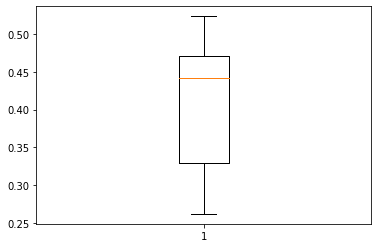

In [18]:
ratios = []
for x in range(10,50,10):
    for y in range(10,50,10):
        for z in range(10,50,10):
            vol = x*y*z
            sa = 2*(x*y+x*z+y*z)
            ratio = 36 * np.pi * vol**2/sa**3

            print(ratio)
            ratios.append(ratio)
            
plt.boxplot(np.asarray(ratios))

In [17]:
import numpy as np
get_isoperimetric_ratio(*get_vol_sa(mk))

tensor([2.5857])

In [ ]:
# cube 1/2
# DHW -> (DxHxW)^3 (2*(DxH) + 2*(D*W) + 2*(H*W))

In [51]:
r = []

for batch in tdl:
    yb = batch[1].unsqueeze(1)
    vol, sa = get_vol_sa(yb)
    r.append(get_isoperimetric_ratio(vol, sa))
    print("next")

 shape  torch.Size([20, 1, 144, 144, 144])
next
 shape  torch.Size([20, 1, 144, 144, 144])
next
 shape  torch.Size([20, 1, 144, 144, 144])
next
 shape  torch.Size([20, 1, 144, 144, 144])
next
 shape  torch.Size([20, 1, 144, 144, 144])
next
 shape  torch.Size([20, 1, 144, 144, 144])
next
 shape  torch.Size([20, 1, 144, 144, 144])
next


RuntimeError: DataLoader worker (pid 139072) is killed by signal: Killed. 

In [55]:
rt = torch.cat(r, dim=0)
rt.shape

torch.Size([140])

(array([ 2.,  3.,  9., 19., 26., 24., 24., 24.,  5.,  4.]),
 array([0.6344859 , 0.65519446, 0.6759031 , 0.69661164, 0.7173202 ,
        0.73802876, 0.7587374 , 0.77944595, 0.8001545 , 0.8208631 ,
        0.8415717 ], dtype=float32),
 <BarContainer object of 10 artists>)

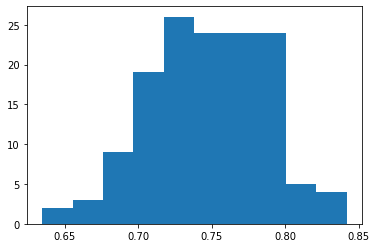

In [57]:
plt.hist(np.asarray(rt))

In [53]:
vol, sa = get_vol_sa(yb)

 shape  torch.Size([20, 1, 144, 144, 144])


In [50]:
vol

tensor([2160, 1838, 2397, 2926, 3910, 2654, 2785, 2401, 2608, 2148, 2560, 2445,
        3368, 2930, 2014, 2636, 3448, 2511, 3336, 3954])

In [46]:
r = get_isoperimetric_ratio(vol, sa)

In [48]:
r

tensor([0.7587, 0.7808, 0.7774, 0.7395, 0.7316, 0.7333, 0.7665, 0.7800, 0.7786,
        0.7657, 0.7593, 0.7886, 0.7387, 0.7061, 0.7795, 0.7362, 0.6951, 0.6488,
        0.7284, 0.6968])

In [39]:
yb[0].calc_volume()

2160.0

In [31]:
get_vol_sa(yb)

IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 4)

In [12]:
start = time.time()
batch = torch.stack([x

print(batch.shape)

elapsed = time.time() - start
print(f"Elapsed: {elapsed:0.2f}.")

RuntimeError: stack expects each tensor to be equal size, but got [260, 260, 149] at entry 0 and [148, 256, 256] at entry 1

In [10]:
start = time.time()

vols_sa = get_vol_sa(torch.stack())

#quotients = [get_isoperimetric_ratio(*get_vol_sa(Iso(1)(item)[1])) for item in all_lbl_items[:2]]


# for item in all_lbl_items:
#     x,y = Iso(1)(item)
#     y_vol, y_sa = get_vol_sa(y)
#     print("vol", y_vol, "sa", y_sa)
#     quotient = get_isoperimetric_ratio(y_vol, y_sa)
#     print("quotient", quotient)
    
elapsed = time.time() - start
print(f"Elapsed: {elapsed:.2f} s for {len(all_lbl_items)} items")

Full lbl items: 335
Removed 2 weird, new total lbl items: 333
train, valid, test 201 66 66 total 333
Cross label items:  418
All label items:  751
Test label items:  619
Elapsed: 2.85 s for 751 items


In [11]:
quotients

[tensor(0.5716), tensor(0.5850)]

# Viz 3D

In [15]:
start = time.time()
side_lens, diff_vols, diff_areas = zip(*[process3d(x, y) for x,y in tls])

elapsed = time.time() - start
print(f"Elapsed {elapsed:.2f} s.")

KeyboardInterrupt: 

In [ ]:
def get_isoperimetric_ratio()

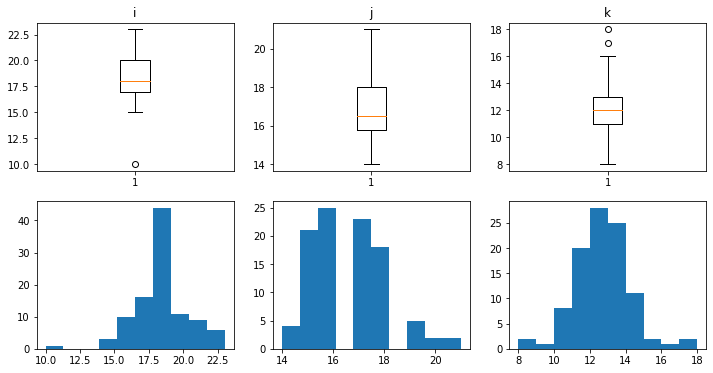

In [18]:
# Plot distribution of bounding box sizes
i,j,k = zip(*side_lens)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
# row 0
axes[0,0].boxplot(i); axes[0,0].set_title("i")
axes[0,1].boxplot(j); axes[0,1].set_title("j")
axes[0,2].boxplot(k); axes[0,2].set_title("k")
# row 1
axes[1,0].hist(i); axes[0,0].set_title("i")
axes[1,1].hist(j); axes[0,1].set_title("j")
axes[1,2].hist(k); axes[0,2].set_title("k")
plt.show()

In [19]:
items[0][0]

'/gpfs/data/oermannlab/private_data/DeepPit/sample_other_dsets/AIBL/263/MPRAGE_ADNI_confirmed/2009-11-20_09_25_07.0/S91498/las_no_n4.nii'

In [29]:
# Pick the 3 smallest and 3 largest from each as outliers
def get_outlier_idxs(arr, n=3):
    idxs = range(len(side_lens))
    sort = sorted(idxs, key=lambda i: arr[i])
    return sort[:n] + sort[-1*n:]

# get outliers in each side len (width, height, depth)
i_outlier_idxs = get_outlier_idxs(i,3)
j_outlier_idxs = get_outlier_idxs(j,3)
k_outlier_idxs = get_outlier_idxs(k,3)

# get unique (note dict is insertion-ordered)
outlier_idxs  = list(dict.fromkeys(i_outlier_idxs + j_outlier_idxs + k_outlier_idxs))

# print the folder name
cross_src = f"{data_src}/sample_other_dsets"
def get_folder(fn): return re.search("(.*?\/.*?)\/", fn[len(cross_src)+1:]).groups(0)[0] #return re.search("\/(\d+)\/", fn).groups(0)[0]

def get_lbl(idx):
    lbl_str = ""
    for dim, lst in zip(("i","j","k"), (i_outlier_idxs, j_outlier_idxs, k_outlier_idxs)): 
        try:
            i  = lst.index(idx)
            sz = "small" if lst.index(idx) < 3 else "large" 
            if lbl_str == "":
                lbl_str += f"outlier: {dim} {sz} #{i%3}"
            else:
                lbl_str += f", {dim} {sz} #{i%3}"
        except:
            pass
    return lbl_str
        
print("Outlier idxs: ", sorted(outlier_idxs))
print("Outlier fns: ", sorted([get_folder(items[idx][0]) for idx in outlier_idxs]), sep="\n"); print()
print("Outlier fn lbls: ", *[f"Idx {idx}. Lbl: {get_lbl(idx)}. Fn: {get_folder(items[idx][0])}" for idx in outlier_idxs], sep="\n")


Outlier idxs:  [0, 19, 21, 57, 60, 64, 66, 70, 75, 76, 93, 98]
Outlier fns: 
['ABVIB/113', 'ABVIB/167', 'ABVIB/209', 'ABVIB/224', 'ABVIB/226', 'ABVIB/69', 'ADNI1_Complete_1Yr_1.5T/012_S_1321', 'AIBL/207', 'AIBL/263', 'ICMB/UCLA_1146', 'PPMI/3107', 'PPMI/3116']

Outlier fn lbls: 
Idx 0. Lbl: outlier: i small #0, j large #1, k large #1. Fn: AIBL/263
Idx 19. Lbl: outlier: i small #1. Fn: AIBL/207
Idx 21. Lbl: outlier: i small #2, k small #2. Fn: ICMB/UCLA_1146
Idx 57. Lbl: outlier: i large #0. Fn: ADNI1_Complete_1Yr_1.5T/012_S_1321
Idx 64. Lbl: outlier: i large #1, j large #2, k large #2. Fn: ABVIB/226
Idx 60. Lbl: outlier: i large #2. Fn: ABVIB/69
Idx 66. Lbl: outlier: j small #0. Fn: ABVIB/209
Idx 70. Lbl: outlier: j small #1. Fn: ABVIB/224
Idx 75. Lbl: outlier: j small #2, k small #0. Fn: ABVIB/167
Idx 98. Lbl: outlier: j large #0. Fn: PPMI/3116
Idx 76. Lbl: outlier: k small #1. Fn: ABVIB/113
Idx 93. Lbl: outlier: k large #0. Fn: PPMI/3107


# Viz

In [36]:
def get_lbl(idx):
    for dim, lst in zip(("i","j","k"), (i_outlier_idxs, j_outlier_idxs, k_outlier_idxs)): 
        try:
            i  = lst.index(idx)
            sz = "small" if lst.index(idx) < 3 else "large" 
            return f"outlier: {dim} {sz} #{i%3}"
        except:
            pass

Count 1. Fn: AIBL/263/. Descr: outlier: i small #0.


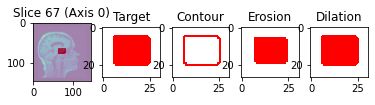

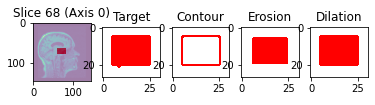

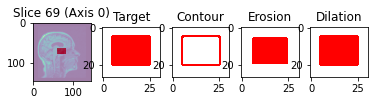

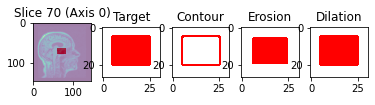

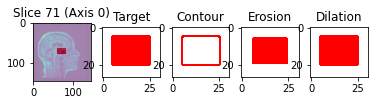

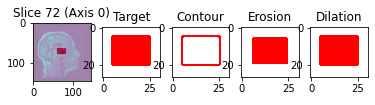

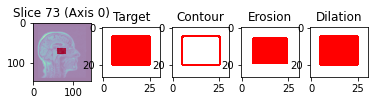

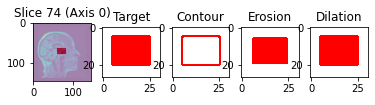

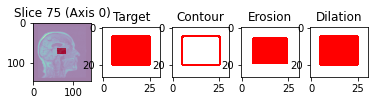

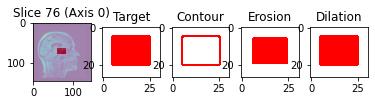

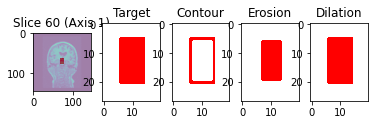

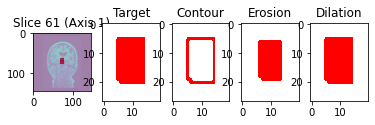

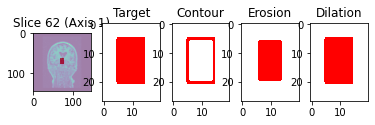

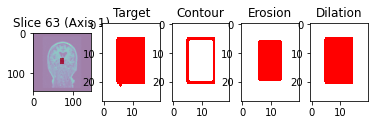

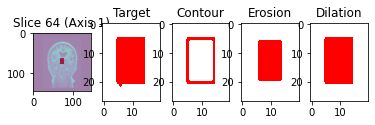

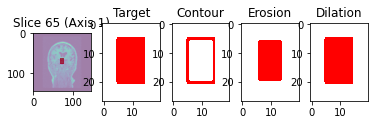

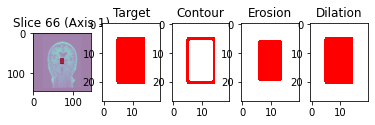

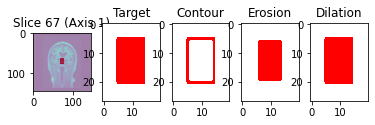

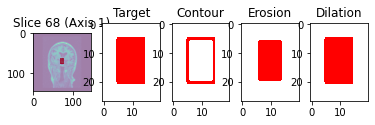

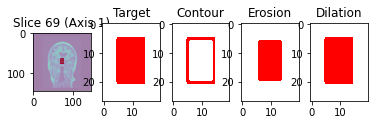

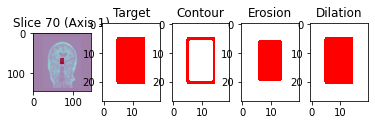

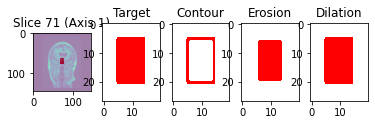

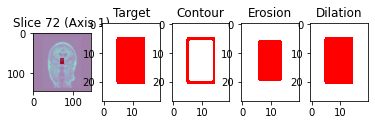

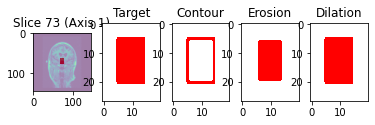

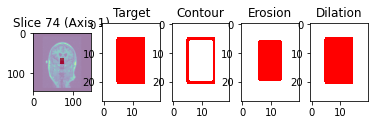

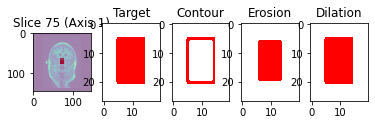

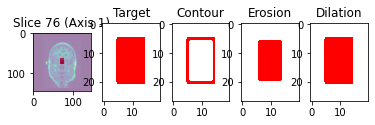

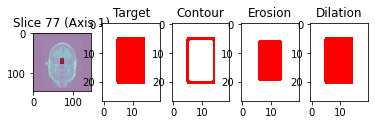

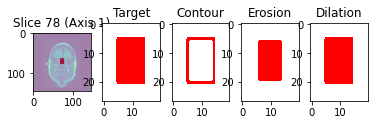

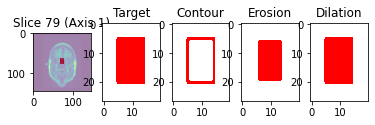

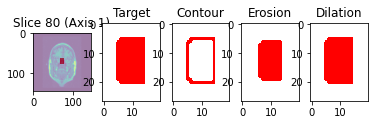

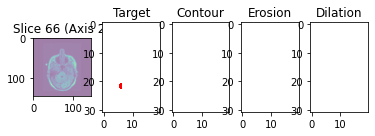

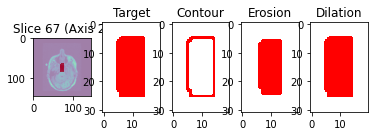

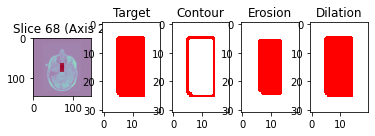

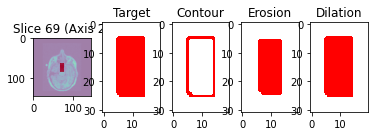

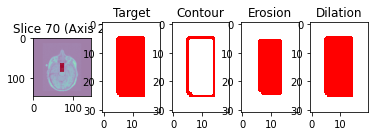

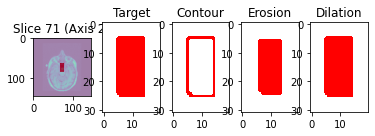

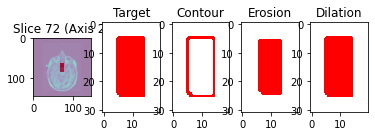

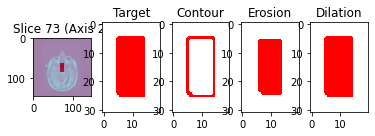

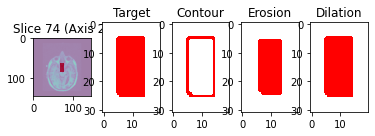

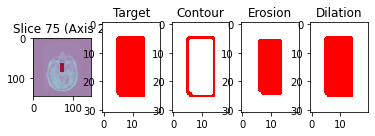

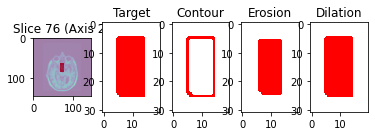

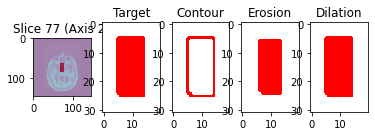

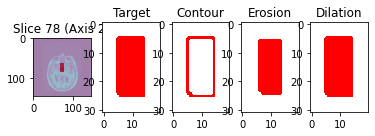

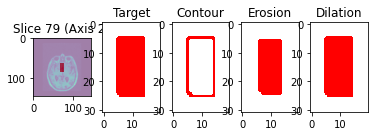

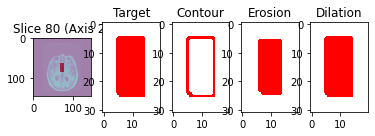

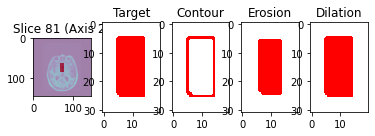

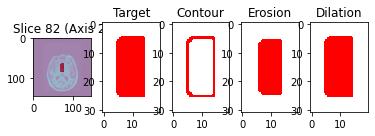

**********
Count 2. Fn: AIBL/207/. Descr: outlier: i small #1.


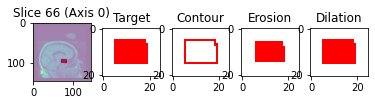

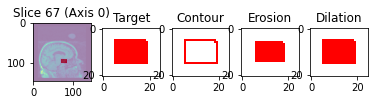

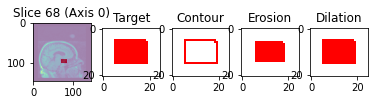

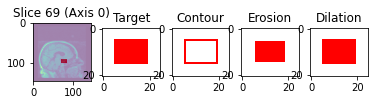

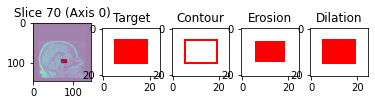

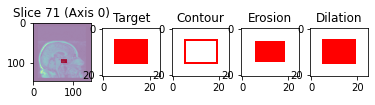

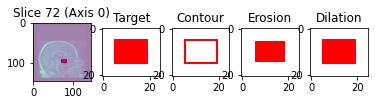

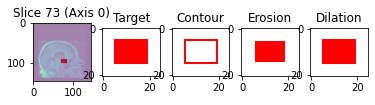

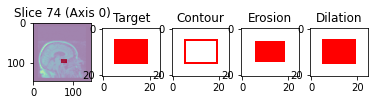

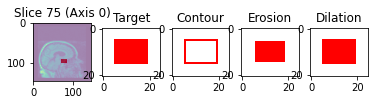

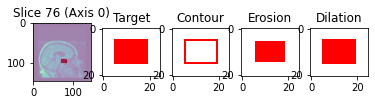

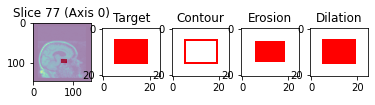

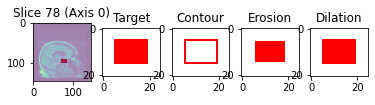

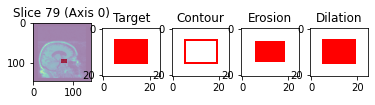

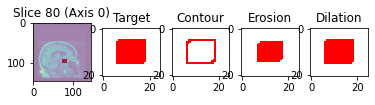

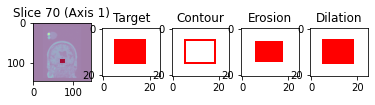

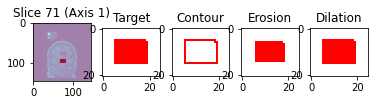

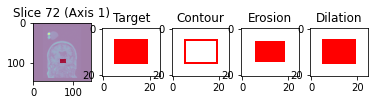

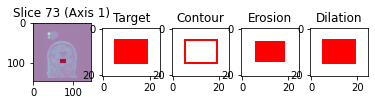

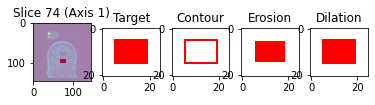

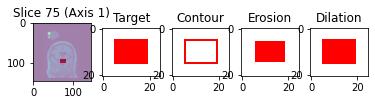

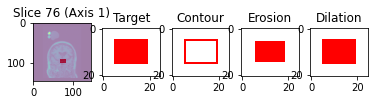

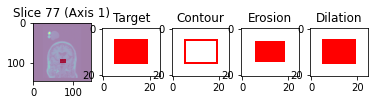

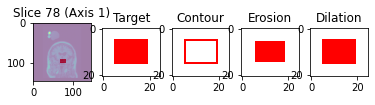

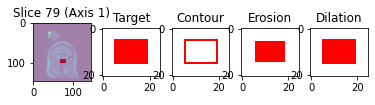

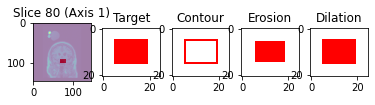

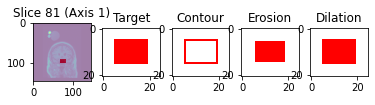

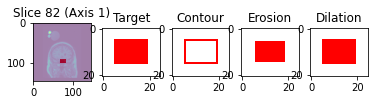

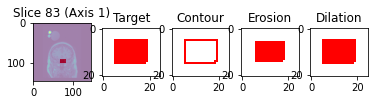

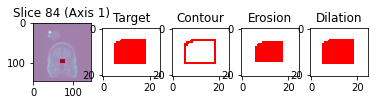

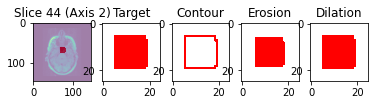

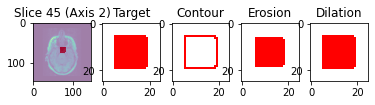

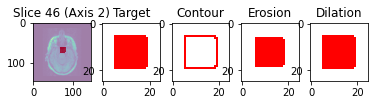

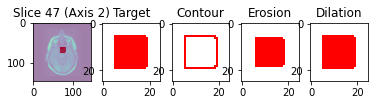

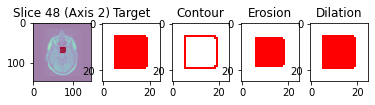

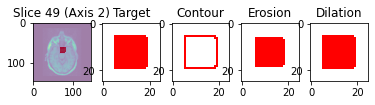

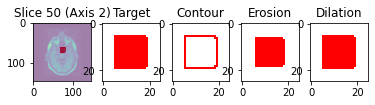

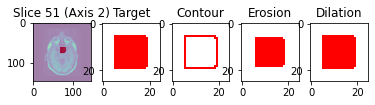

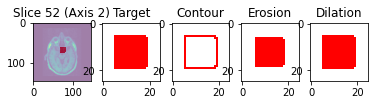

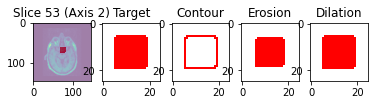

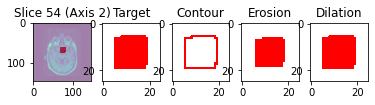

**********
Count 3. Fn: ICMB/UCLA_1146/. Descr: outlier: i small #2.


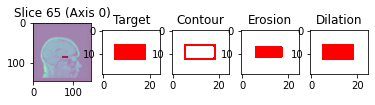

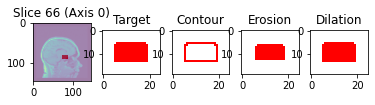

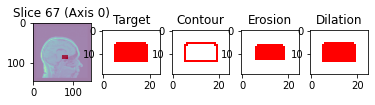

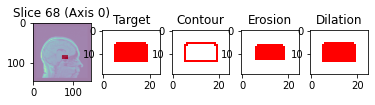

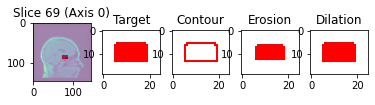

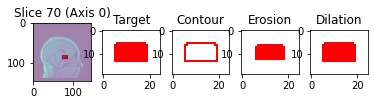

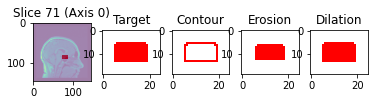

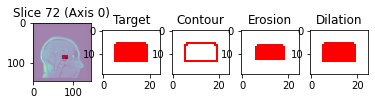

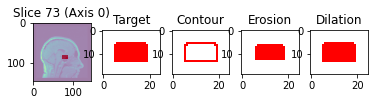

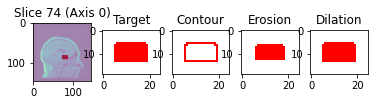

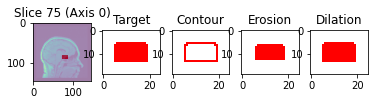

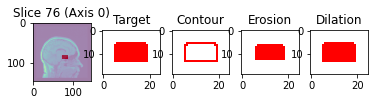

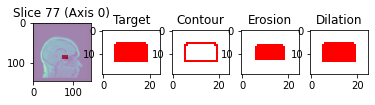

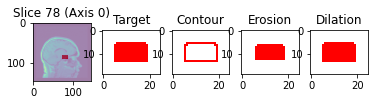

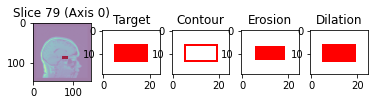

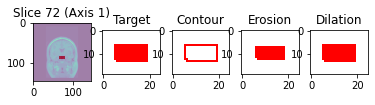

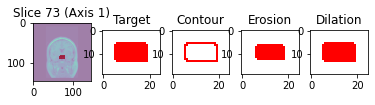

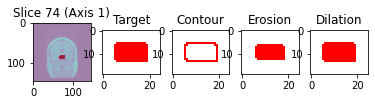

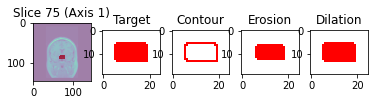

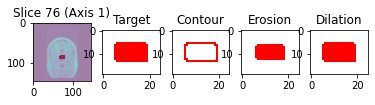

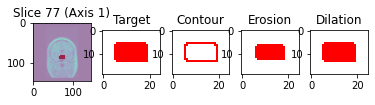

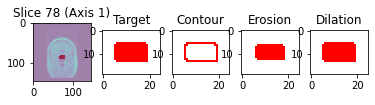

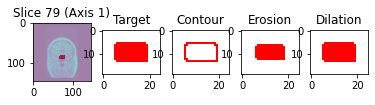

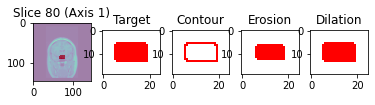

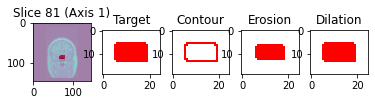

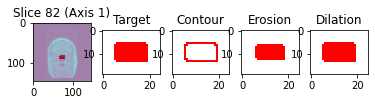

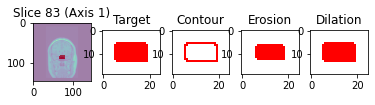

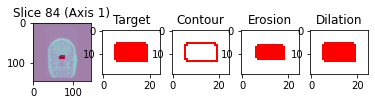

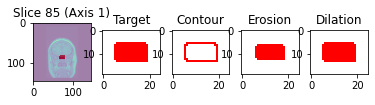

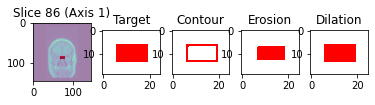

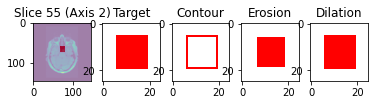

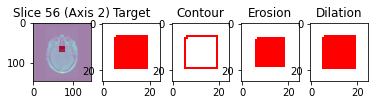

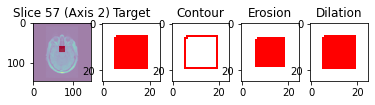

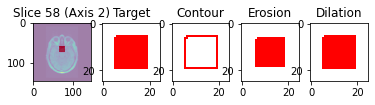

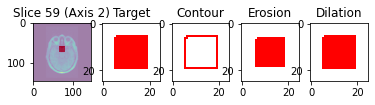

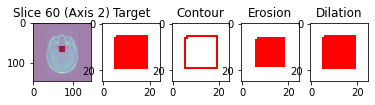

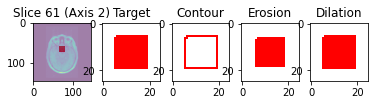

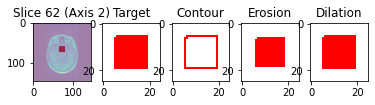

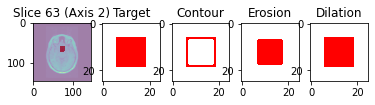

**********
Count 4. Fn: ADNI1_Complete_1Yr_1.5T/012_S_1321/. Descr: outlier: i large #0.


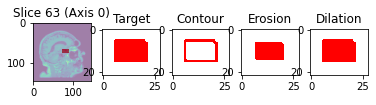

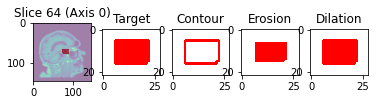

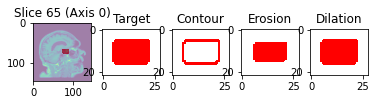

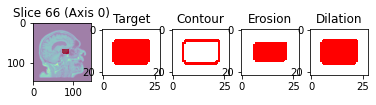

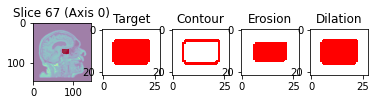

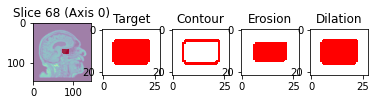

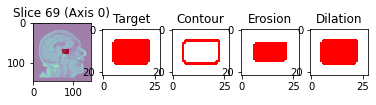

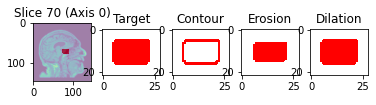

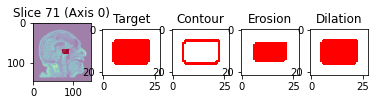

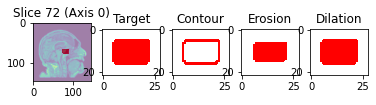

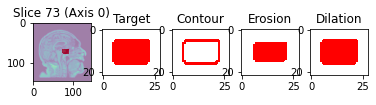

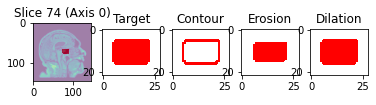

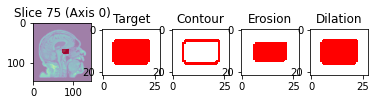

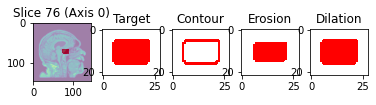

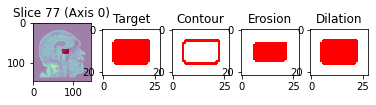

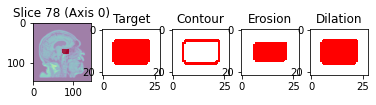

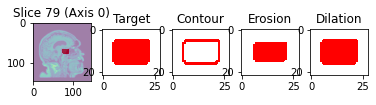

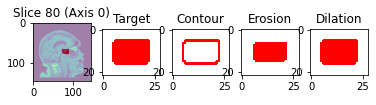

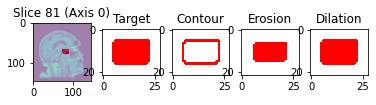

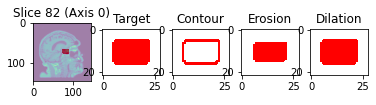

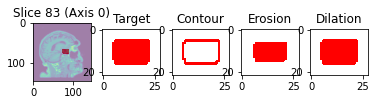

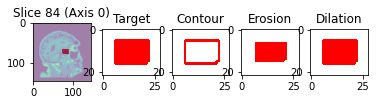

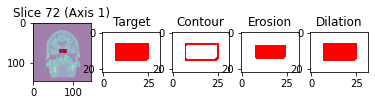

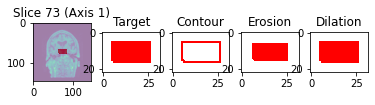

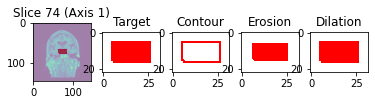

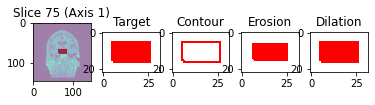

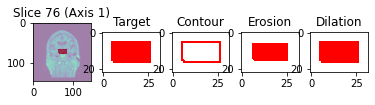

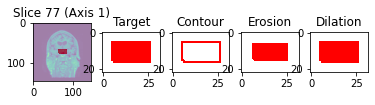

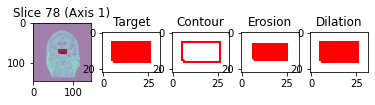

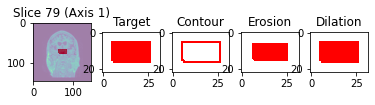

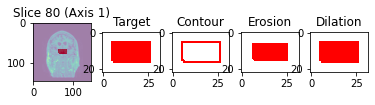

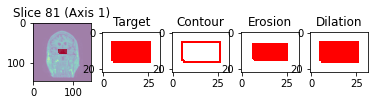

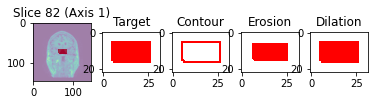

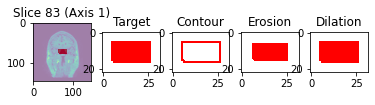

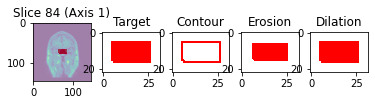

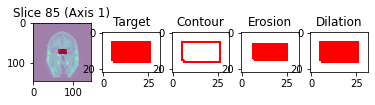

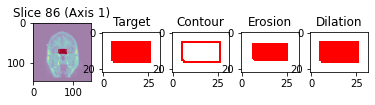

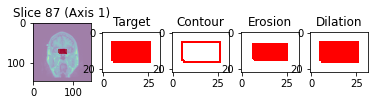

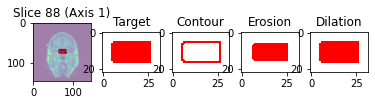

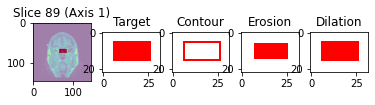

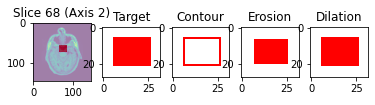

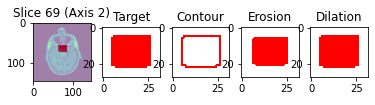

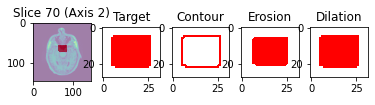

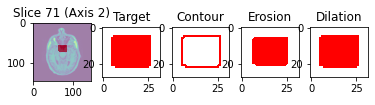

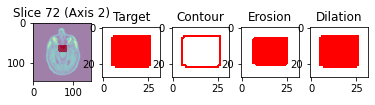

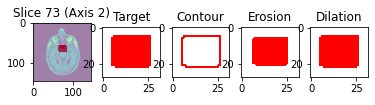

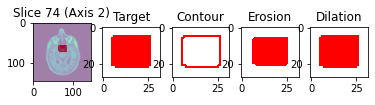

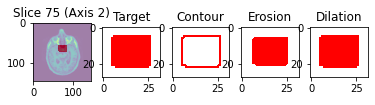

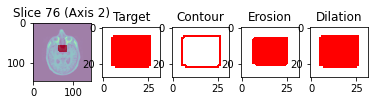

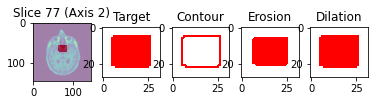

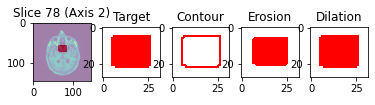

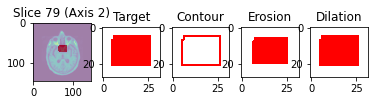

**********
Count 5. Fn: ABVIB/226/. Descr: outlier: i large #1.


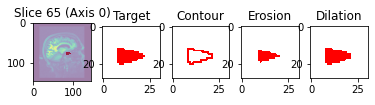

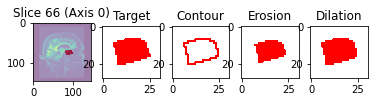

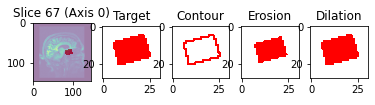

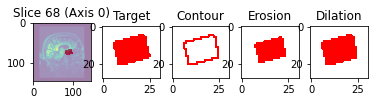

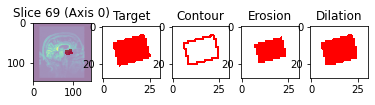

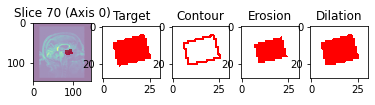

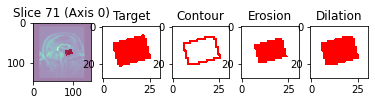

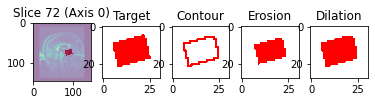

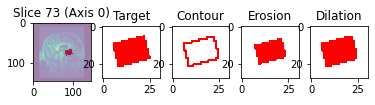

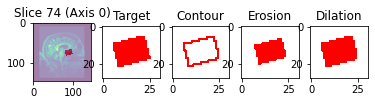

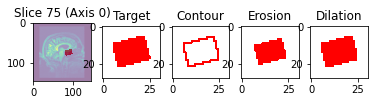

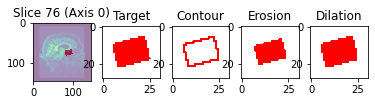

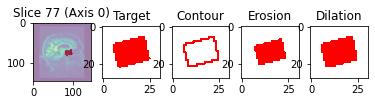

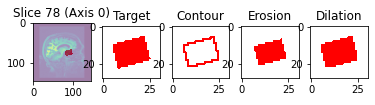

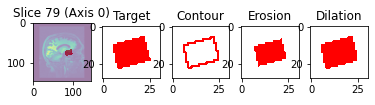

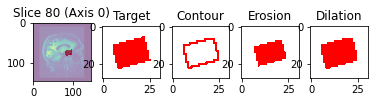

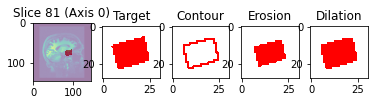

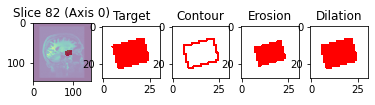

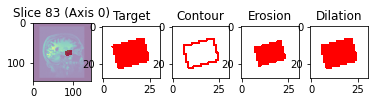

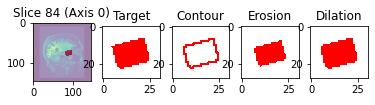

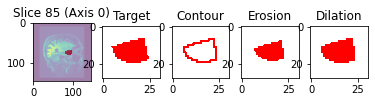

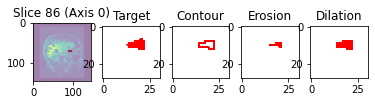

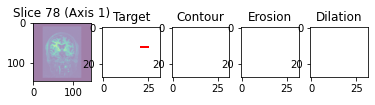

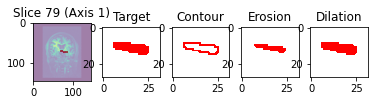

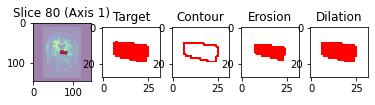

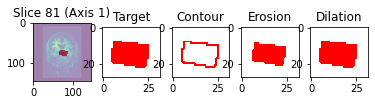

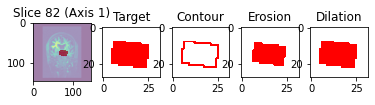

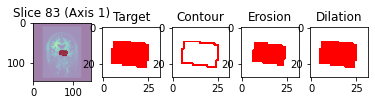

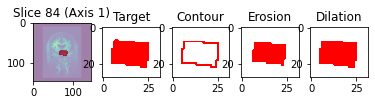

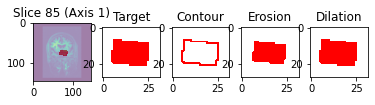

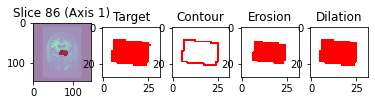

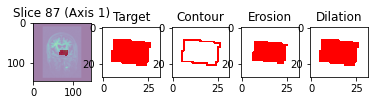

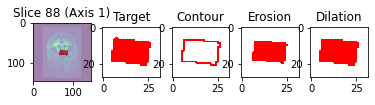

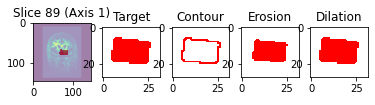

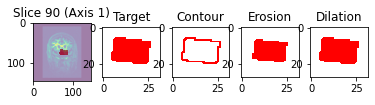

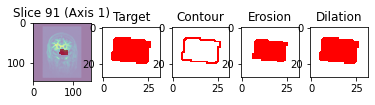

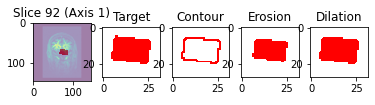

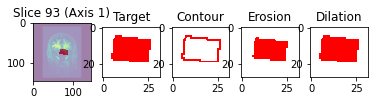

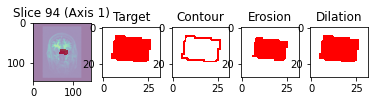

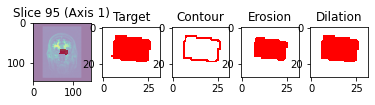

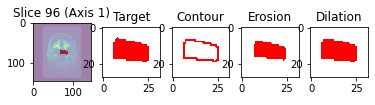

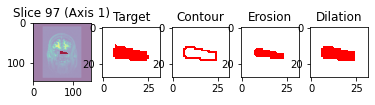

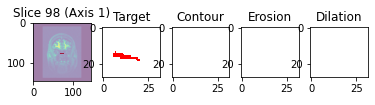

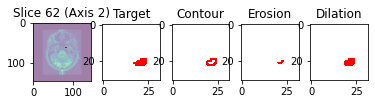

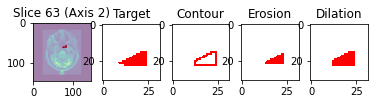

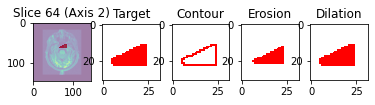

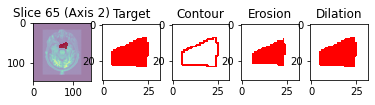

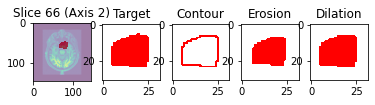

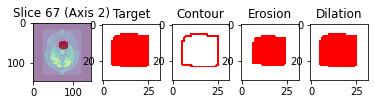

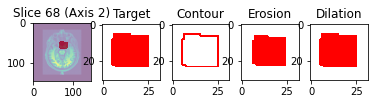

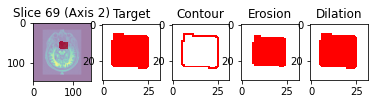

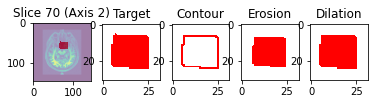

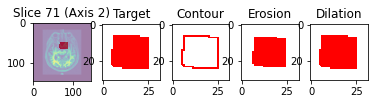

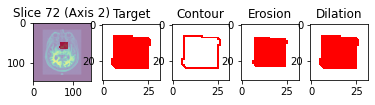

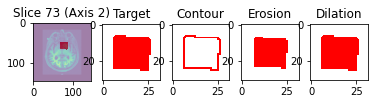

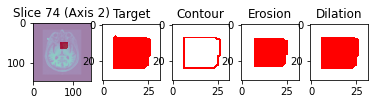

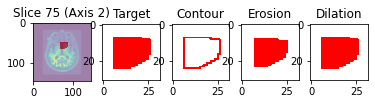

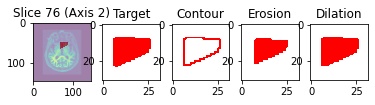

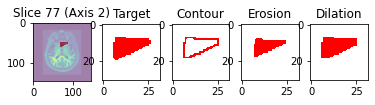

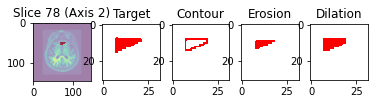

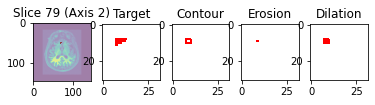

**********
Count 6. Fn: ABVIB/69/. Descr: outlier: i large #2.


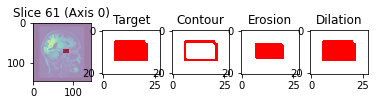

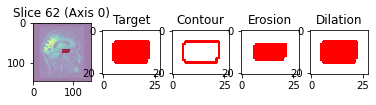

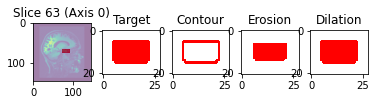

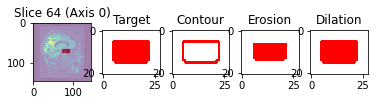

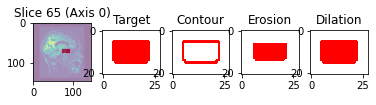

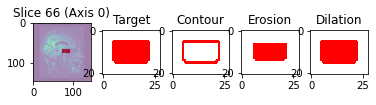

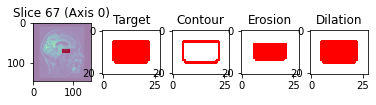

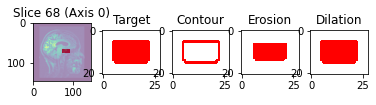

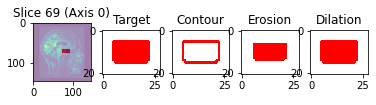

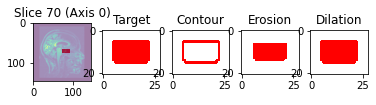

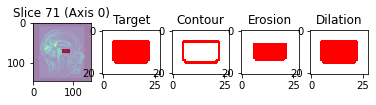

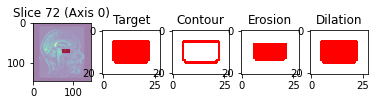

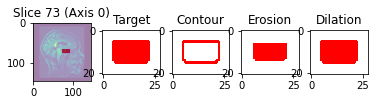

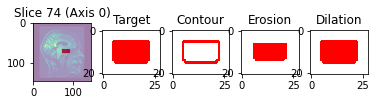

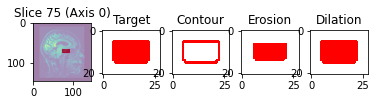

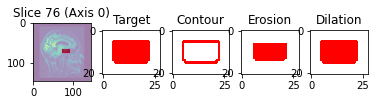

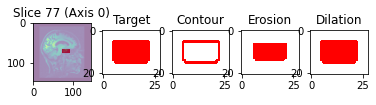

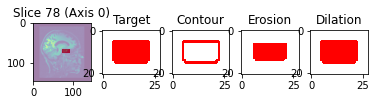

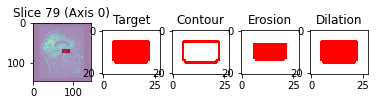

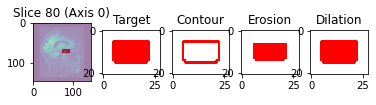

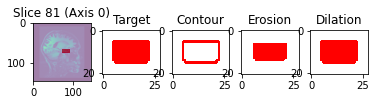

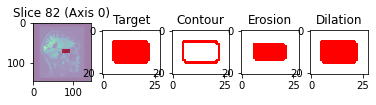

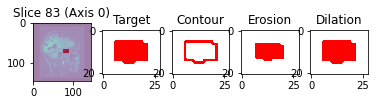

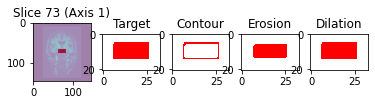

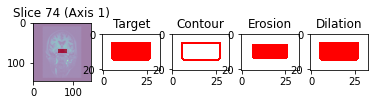

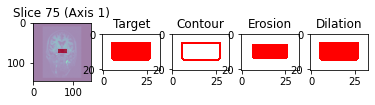

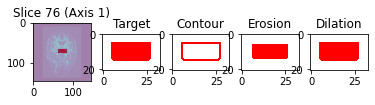

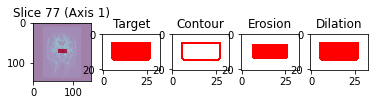

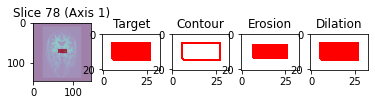

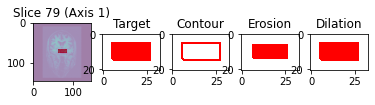

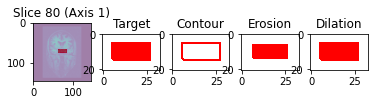

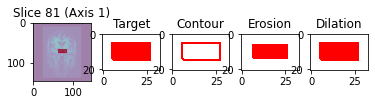

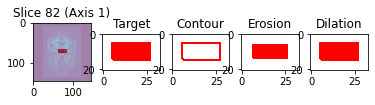

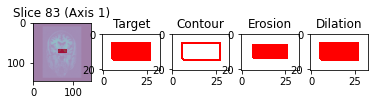

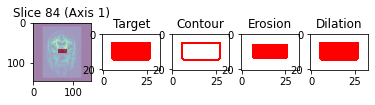

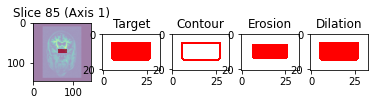

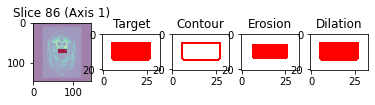

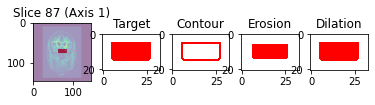

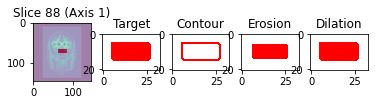

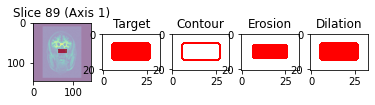

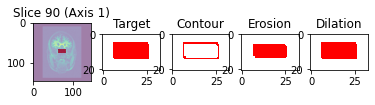

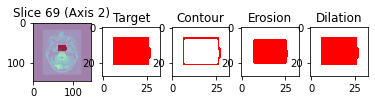

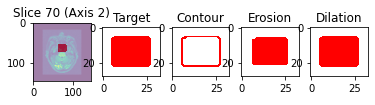

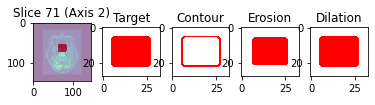

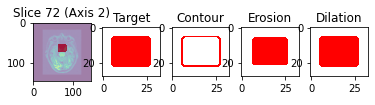

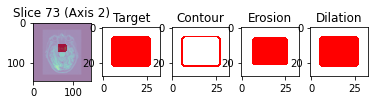

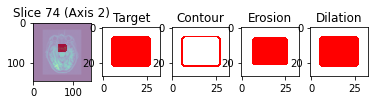

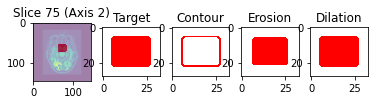

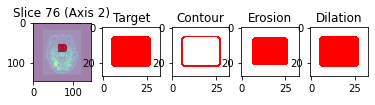

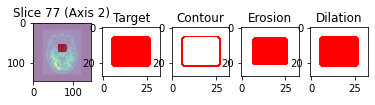

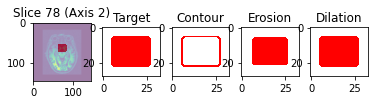

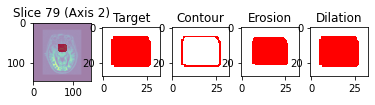

**********
Count 7. Fn: ABVIB/209/. Descr: outlier: j small #0.


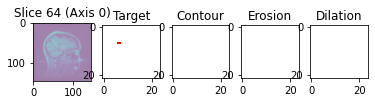

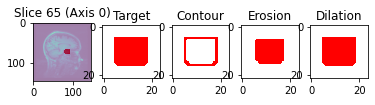

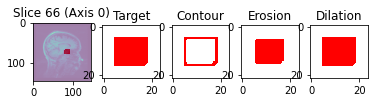

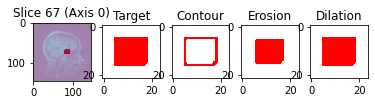

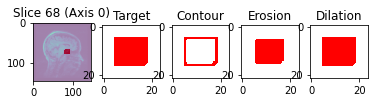

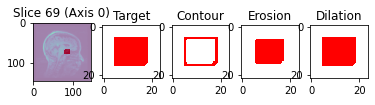

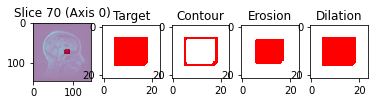

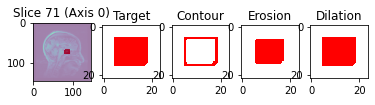

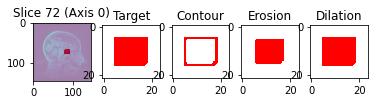

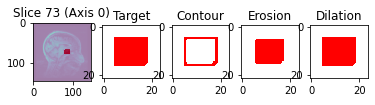

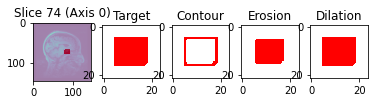

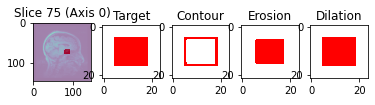

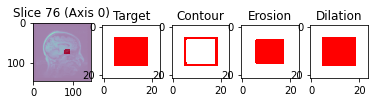

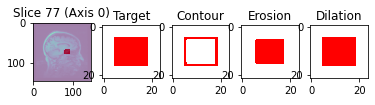

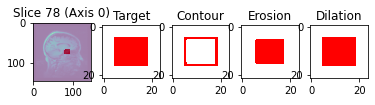

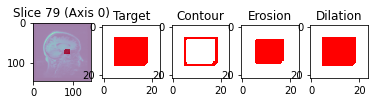

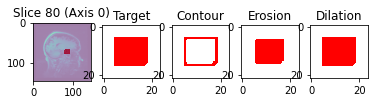

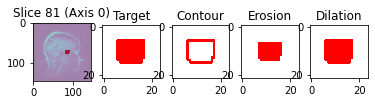

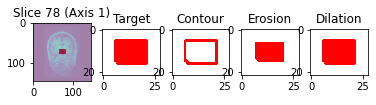

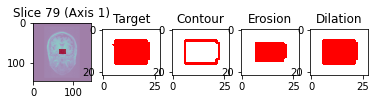

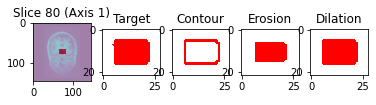

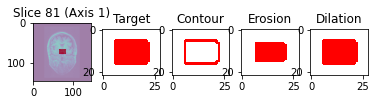

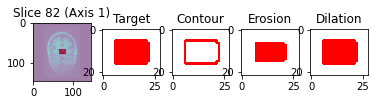

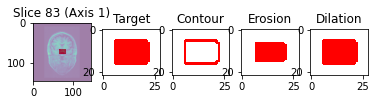

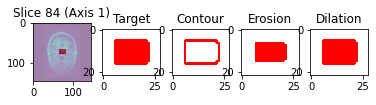

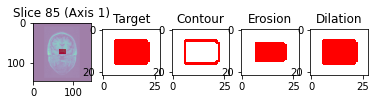

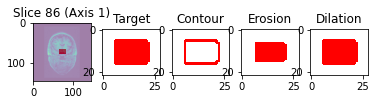

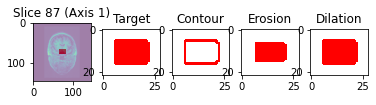

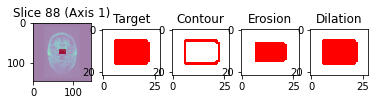

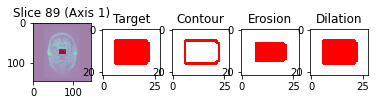

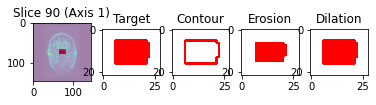

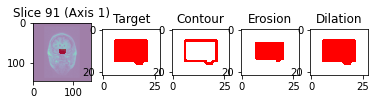

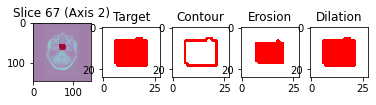

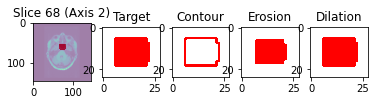

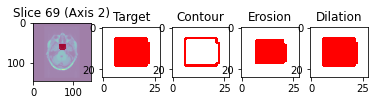

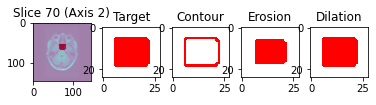

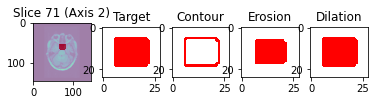

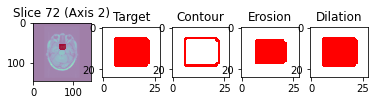

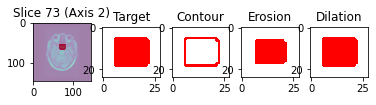

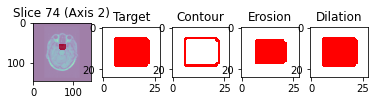

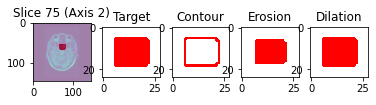

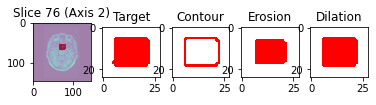

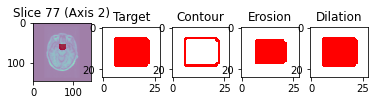

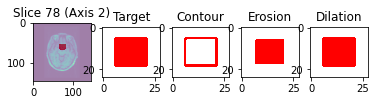

**********
Count 8. Fn: ABVIB/224/. Descr: outlier: j small #1.


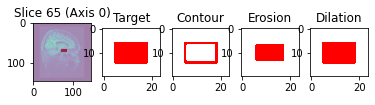

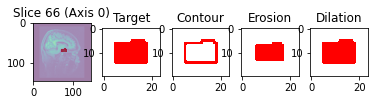

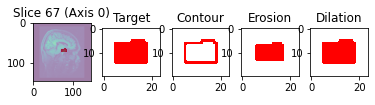

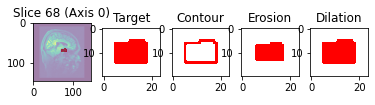

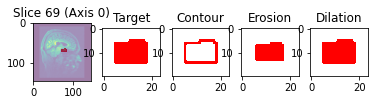

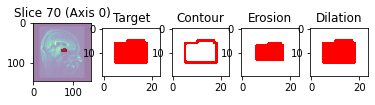

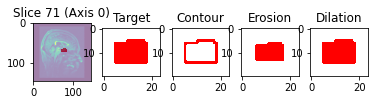

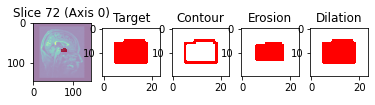

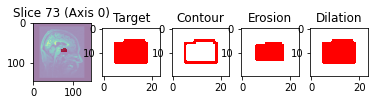

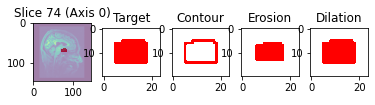

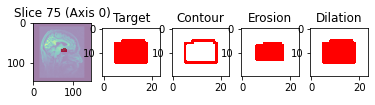

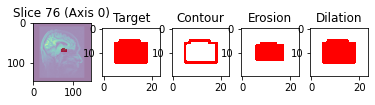

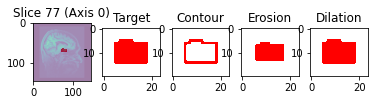

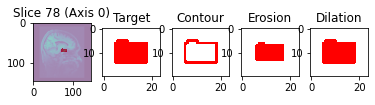

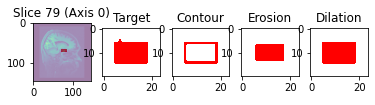

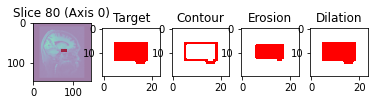

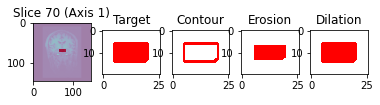

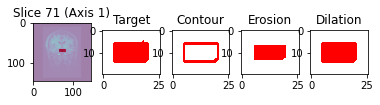

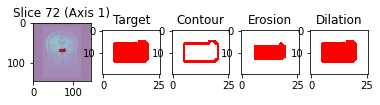

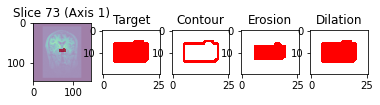

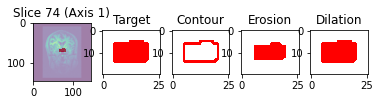

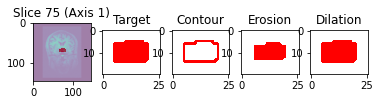

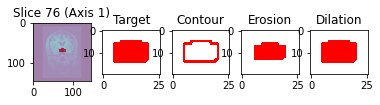

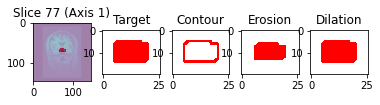

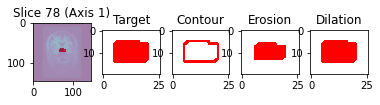

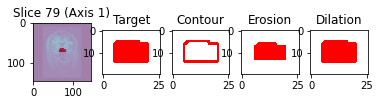

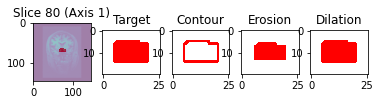

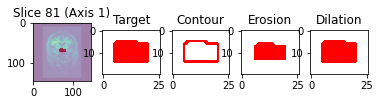

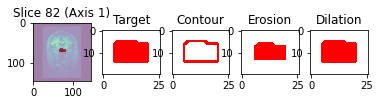

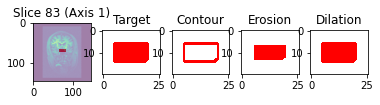

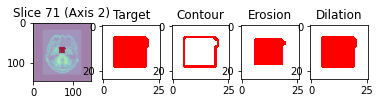

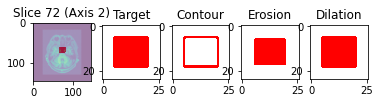

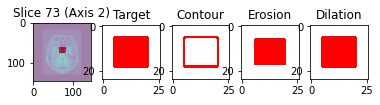

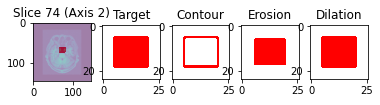

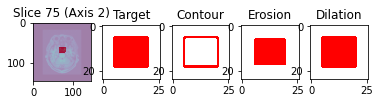

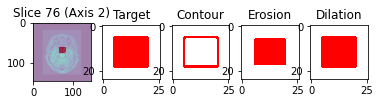

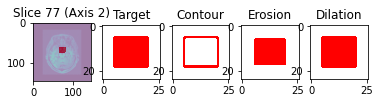

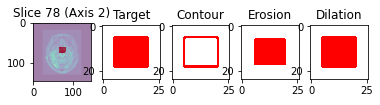

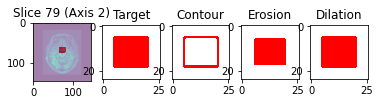

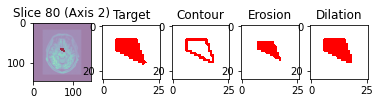

**********
Count 9. Fn: ABVIB/167/. Descr: outlier: j small #2.


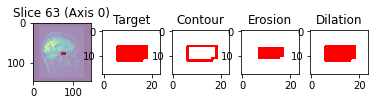

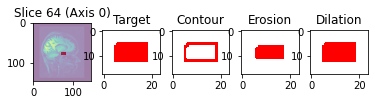

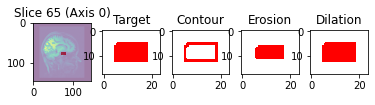

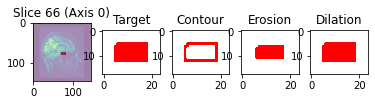

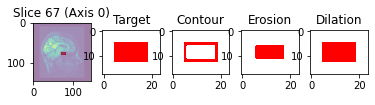

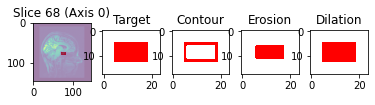

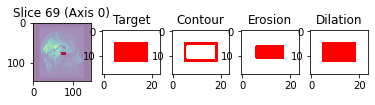

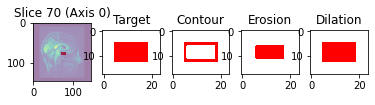

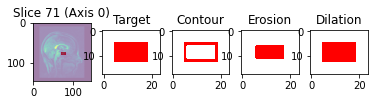

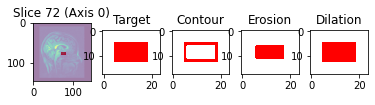

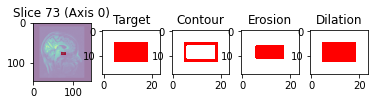

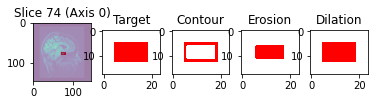

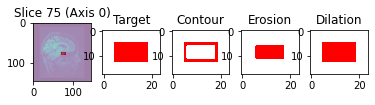

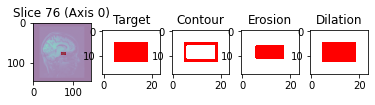

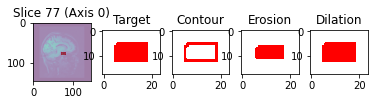

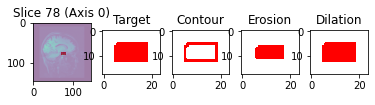

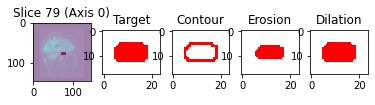

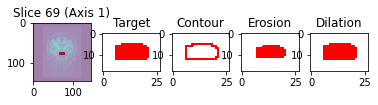

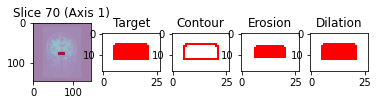

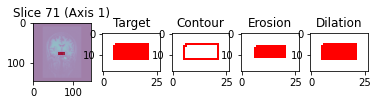

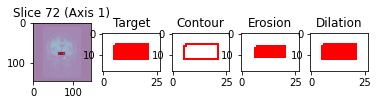

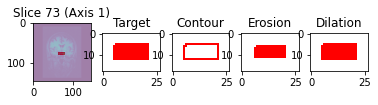

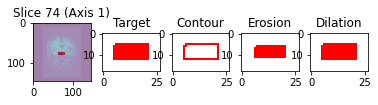

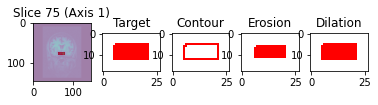

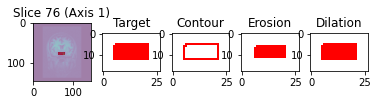

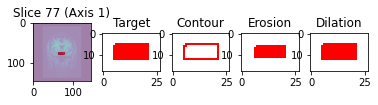

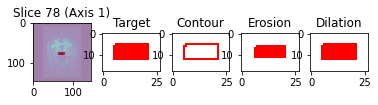

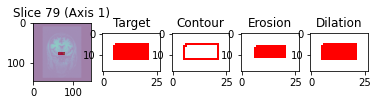

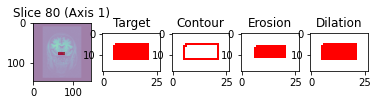

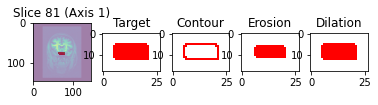

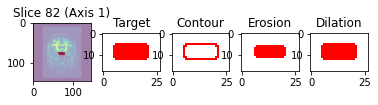

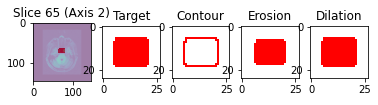

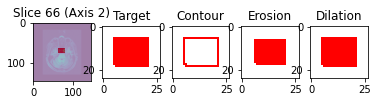

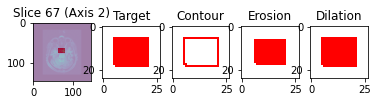

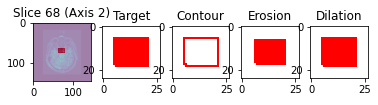

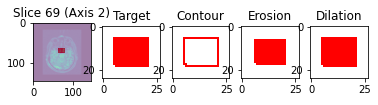

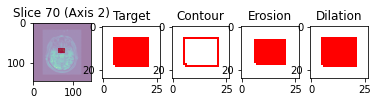

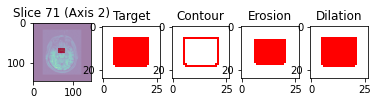

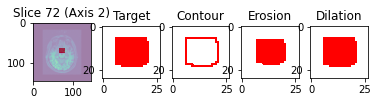

**********
Count 10. Fn: PPMI/3116/. Descr: outlier: j large #0.


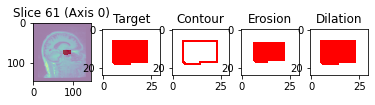

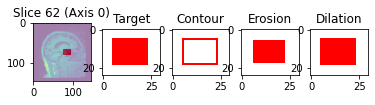

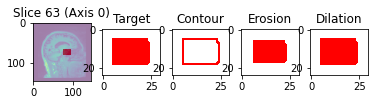

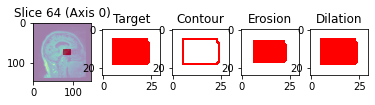

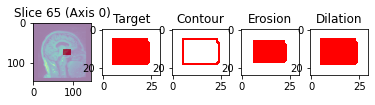

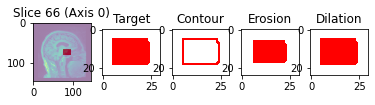

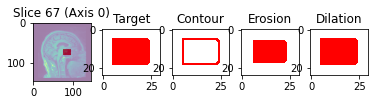

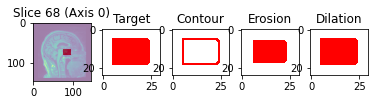

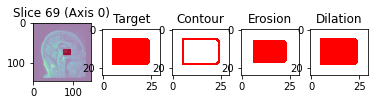

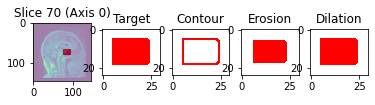

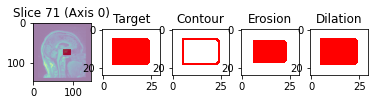

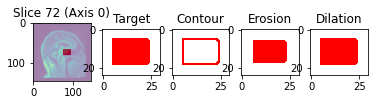

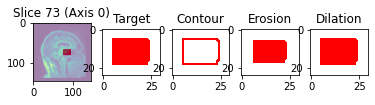

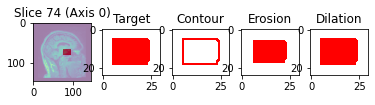

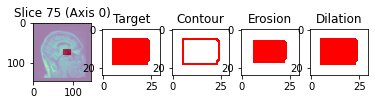

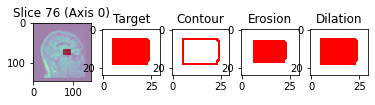

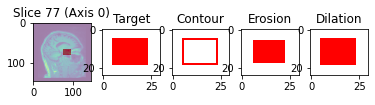

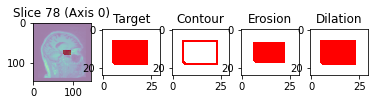

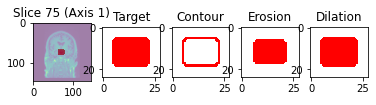

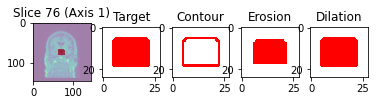

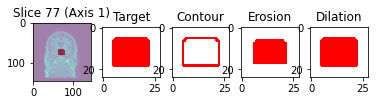

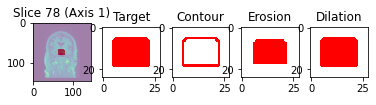

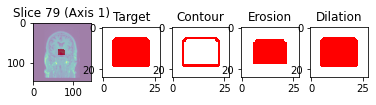

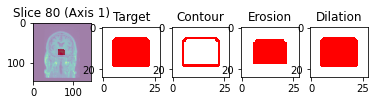

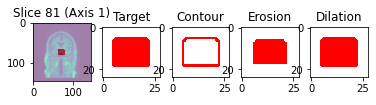

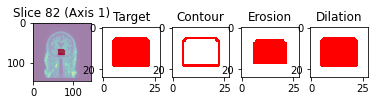

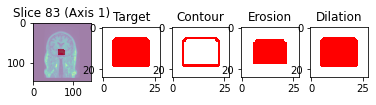

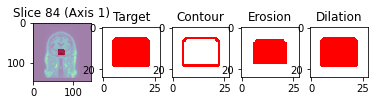

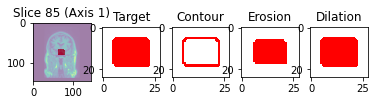

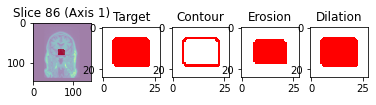

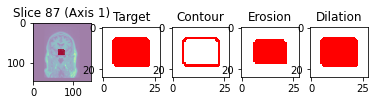

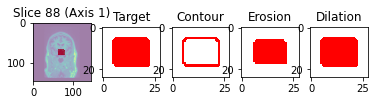

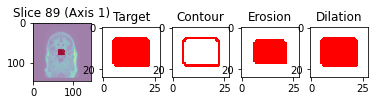

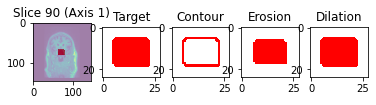

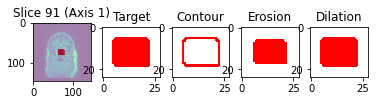

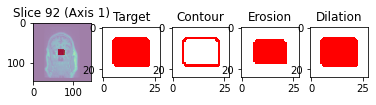

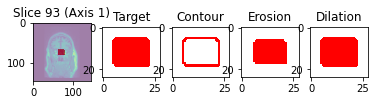

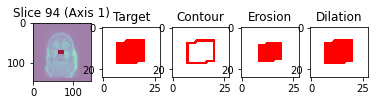

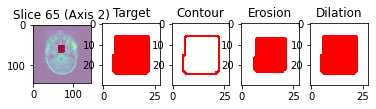

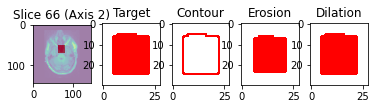

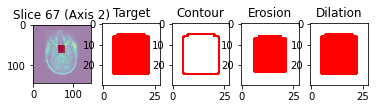

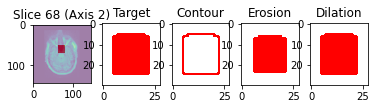

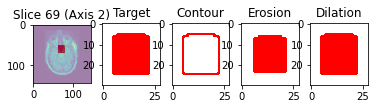

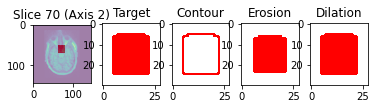

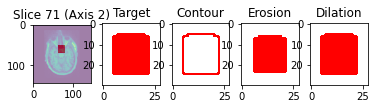

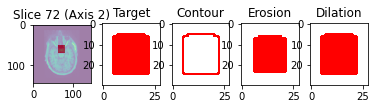

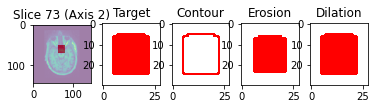

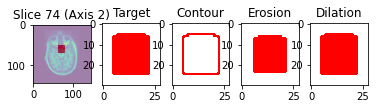

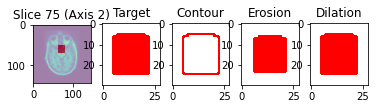

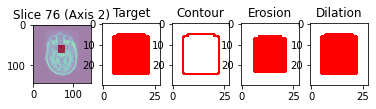

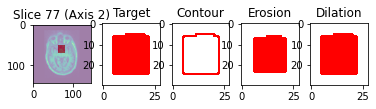

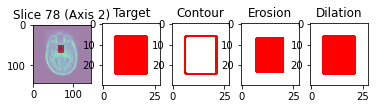

**********
Count 11. Fn: ABVIB/113/. Descr: outlier: k small #1.


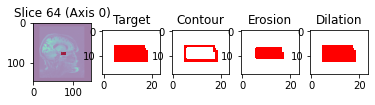

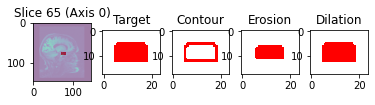

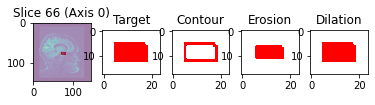

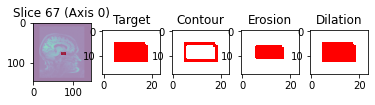

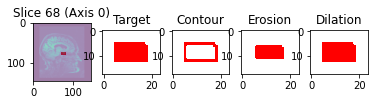

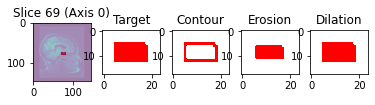

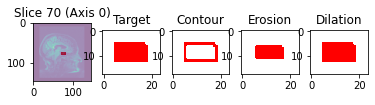

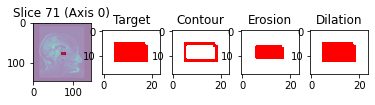

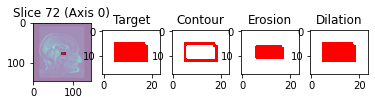

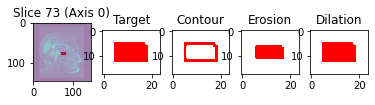

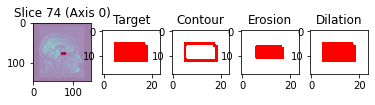

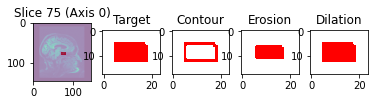

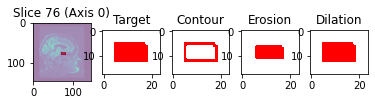

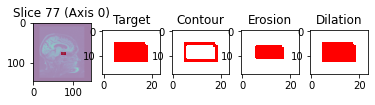

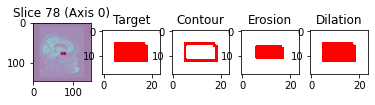

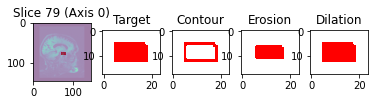

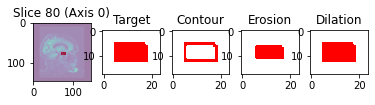

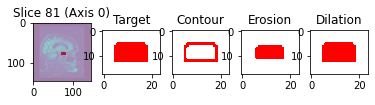

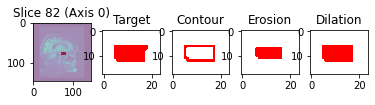

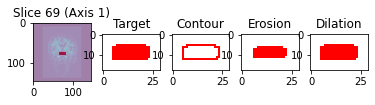

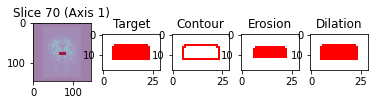

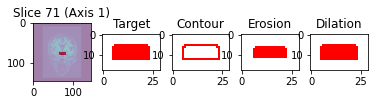

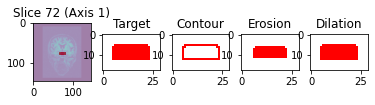

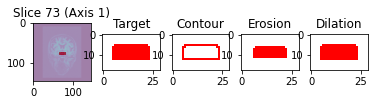

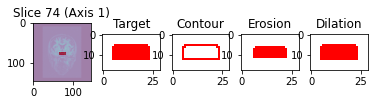

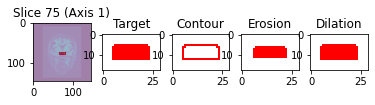

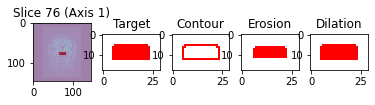

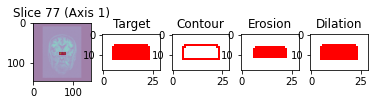

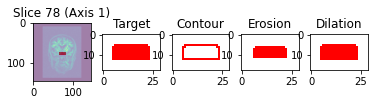

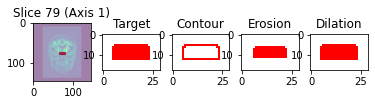

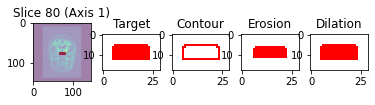

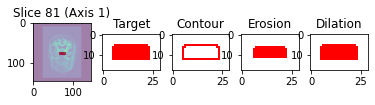

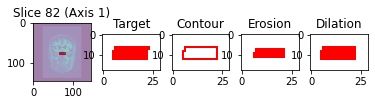

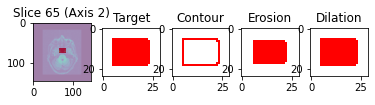

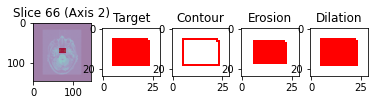

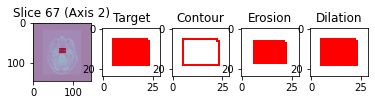

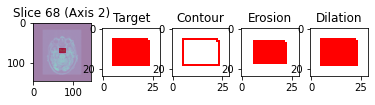

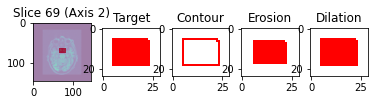

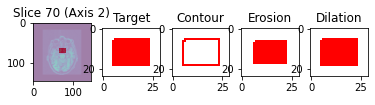

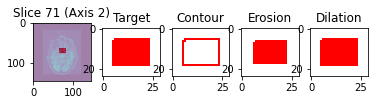

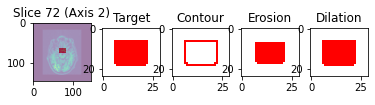

**********
Count 12. Fn: PPMI/3107/. Descr: outlier: k large #0.


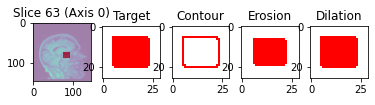

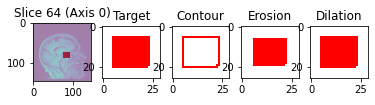

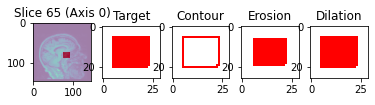

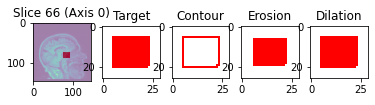

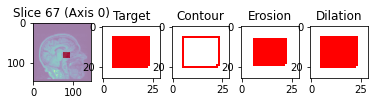

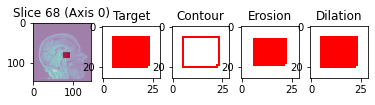

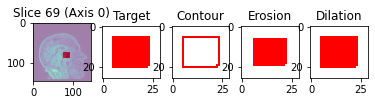

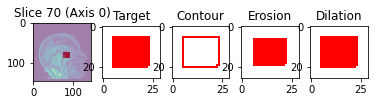

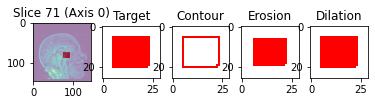

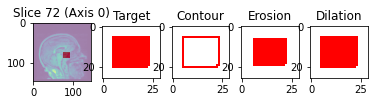

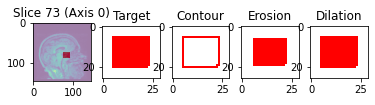

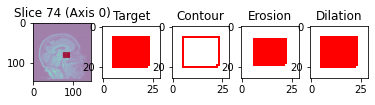

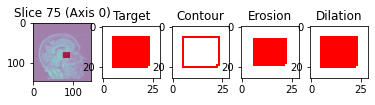

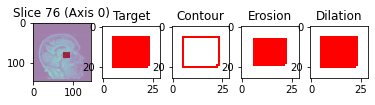

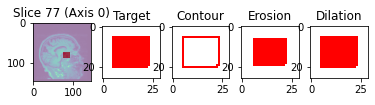

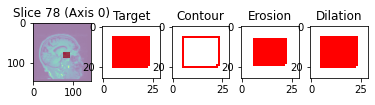

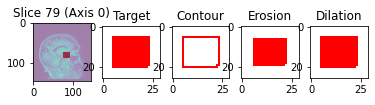

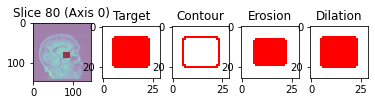

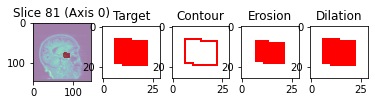

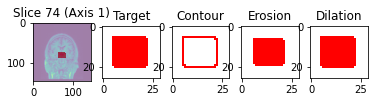

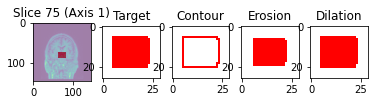

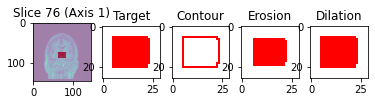

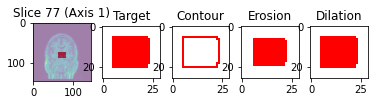

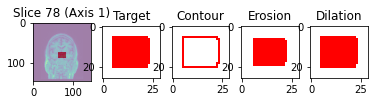

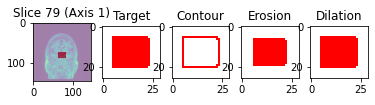

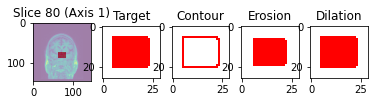

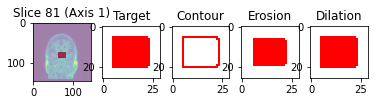

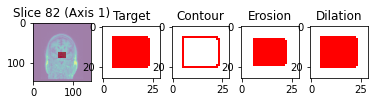

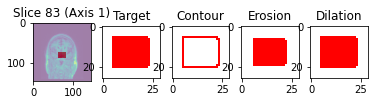

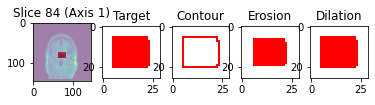

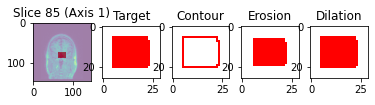

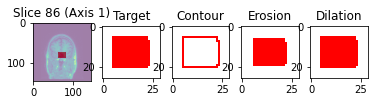

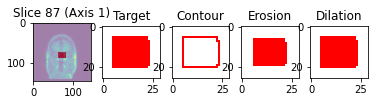

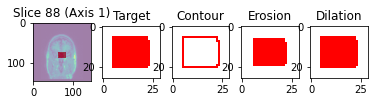

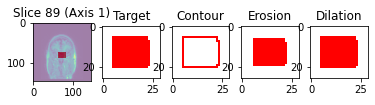

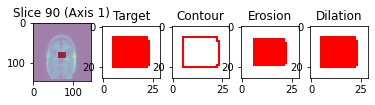

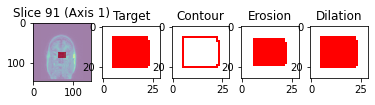

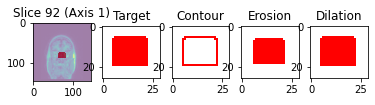

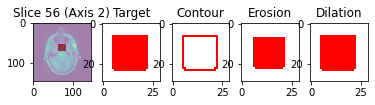

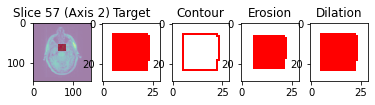

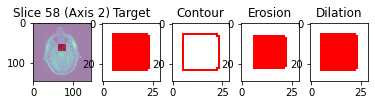

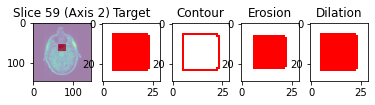

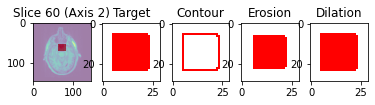

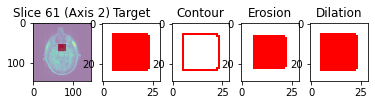

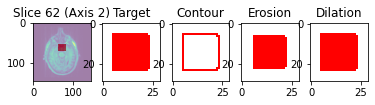

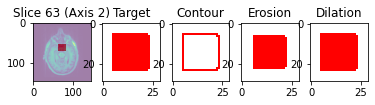

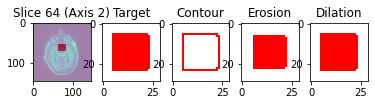

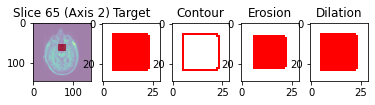

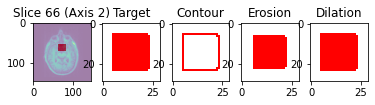

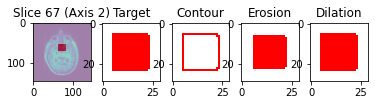

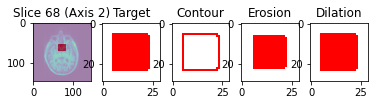

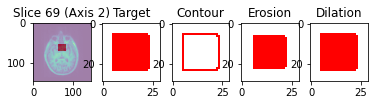

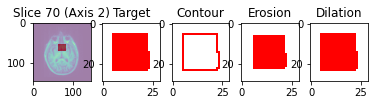

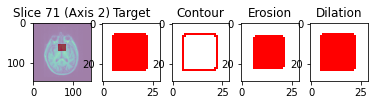

**********


In [37]:
for count,idx in enumerate(outlier_idxs):
    # get data
    x,y = tls[idx]
    fn  = get_folder(items[idx][0])
    
    # plot it
    print(f"Count {count+1}. Fn: {fn}. Descr: {get_lbl(idx)}.")
    plot2d(x,y)
    print("*" * 10)

# Difference between Bbox vs. Perfect Rectangular Prism

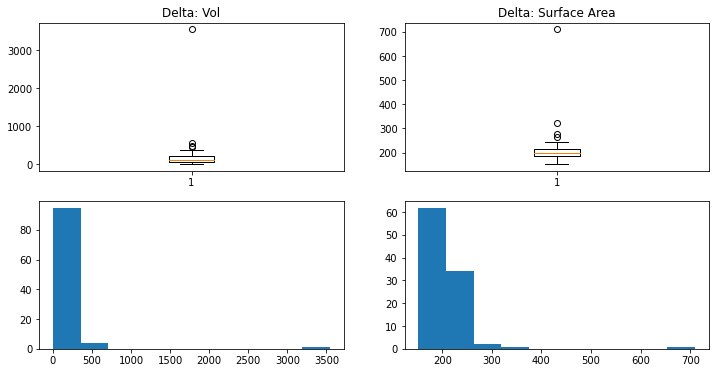

In [30]:
# Plot distribution of bounding box sizes vs expected measure given side lengths
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
# row 0
axes[0,0].boxplot(diff_vols); axes[0,0].set_title("Delta: Vol")
axes[0,1].boxplot(diff_areas); axes[0,1].set_title("Delta: Surface Area")
# row 1
axes[1,0].hist(diff_vols); axes[0,0].set_title("Delta: Vol")
axes[1,1].hist(diff_areas); axes[0,1].set_title("Delta: Surface Area")
plt.show()

In [31]:
# Pick the 3 smallest and 3 largest from each as outliers

# get outliers in each side len (width, height, depth)
vol_outlier_idxs  = get_outlier_idxs(diff_vols,3)
area_outlier_idxs = get_outlier_idxs(diff_areas,3)

# get unique (note dict is insertion-ordered)
outlier_idxs  = list(dict.fromkeys(vol_outlier_idxs + area_outlier_idxs))

def get_lbl(idx):
    lbl_str = ""
    for dim, lst in zip(("vol","area"), (vol_outlier_idxs, area_outlier_idxs)): 
        try:
            i  = lst.index(idx)
            sz = "small" if lst.index(idx) < 3 else "large" 
            if lbl_str == "":
                lbl_str += f"outlier: {dim} {sz} #{i%3}"
            else:
                lbl_str += f", {dim} {sz} #{i%3}"
        except:
            pass
    return lbl_str

print("Outlier idxs: ", sorted(outlier_idxs))
print("Outlier fns: ", sorted([get_folder(items[idx][0]) for idx in outlier_idxs]), sep="\n"); print()
print("Outlier fn lbls: ", *[f"Idx {idx}. Lbl: {get_lbl(idx)}. Fn: {get_folder(items[idx][0])}" for idx in outlier_idxs], sep="\n")


Outlier idxs:  [7, 19, 21, 64, 69, 75, 77, 87, 94]
Outlier fns: 
['ABVIB/159', 'ABVIB/167', 'ABVIB/226', 'ABVIB/228', 'AIBL/207', 'AIBL/99', 'ICMB/UCLA_1146', 'PPMI/3182', 'PPMI/3184']

Outlier fn lbls: 
Idx 77. Lbl: outlier: vol small #0. Fn: ABVIB/159
Idx 69. Lbl: outlier: vol small #1. Fn: ABVIB/228
Idx 94. Lbl: outlier: vol small #2. Fn: PPMI/3182
Idx 7. Lbl: outlier: vol large #0, area large #0. Fn: AIBL/99
Idx 87. Lbl: outlier: vol large #1, area large #1. Fn: PPMI/3184
Idx 64. Lbl: outlier: vol large #2, area large #2. Fn: ABVIB/226
Idx 75. Lbl: outlier: area small #0. Fn: ABVIB/167
Idx 19. Lbl: outlier: area small #1. Fn: AIBL/207
Idx 21. Lbl: outlier: area small #2. Fn: ICMB/UCLA_1146


# Viz

- **Small delta: perfect rectangular prism**
- **Large delta: most unlike rectangular prism**

Count 1. Fn: ABVIB/159. Descr: outlier: vol small #0.


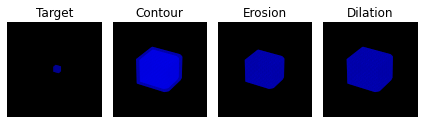

**********
Count 2. Fn: ABVIB/228. Descr: outlier: vol small #1.


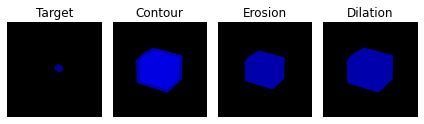

**********
Count 3. Fn: PPMI/3182. Descr: outlier: vol small #2.


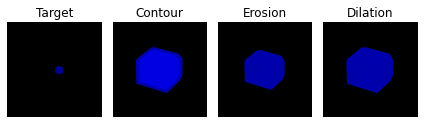

**********
Count 4. Fn: AIBL/99. Descr: outlier: vol large #0, area large #0.


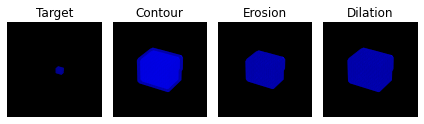

**********
Count 5. Fn: PPMI/3184. Descr: outlier: vol large #1, area large #1.


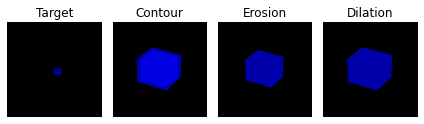

**********
Count 6. Fn: ABVIB/226. Descr: outlier: vol large #2, area large #2.


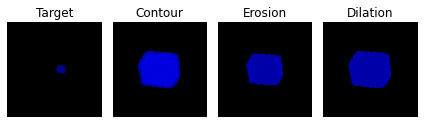

**********
Count 7. Fn: ABVIB/167. Descr: outlier: area small #0.


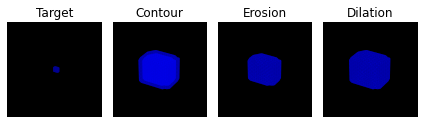

**********
Count 8. Fn: AIBL/207. Descr: outlier: area small #1.


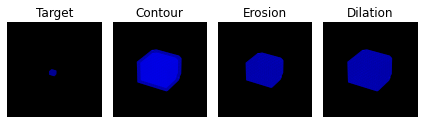

**********
Count 9. Fn: ICMB/UCLA_1146. Descr: outlier: area small #2.


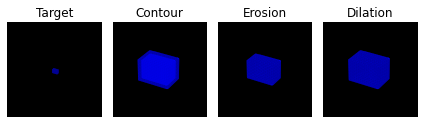

**********


In [32]:
for count,idx in enumerate(outlier_idxs):
    # get data
    x,y = tls[idx]
    fn  = get_folder(items[idx][0])
    
    # plot it
    print(f"Count {count+1}. Fn: {fn}. Descr: {get_lbl(idx)}.")
    process3d(x,y, do_plot=True)
    print("*" * 10)

In [42]:
from nbconvert import HTMLExporter
import codecs
import nbformat

notebook_name = '05c_viz_3d_masks.ipynb'
output_file_name = 'output.html'

exporter = HTMLExporter()
output_notebook = nbformat.read(notebook_name, as_version=4)

output, resources = exporter.from_notebook_node(output_notebook)
codecs.open(output_file_name, 'w', encoding='utf-8').write(output)

# Contour Loss

In [13]:
# DATALOADER PARAMS
bs          = 4
nepochs     = 30
num_workers = 2

# PREPROCESS (Isotropic, PadResize)
# iso       = 3
# maxs      = [87, 90, 90]

iso       = 2
maxs      = [144, 144, 144]

# Train:Valid:Test = 60:20:20
train_pct, valid_pct = .60, .20

# Paths

In [12]:
import os

# Paths to (1) code (2) data (3) saved models
code_src    = "/gpfs/home/gologr01"
data_src    = "/gpfs/data/oermannlab/private_data/DeepPit"
model_src   = "/gpfs/data/oermannlab/private_data/DeepPit/saved_models"

# UMich 
# code src: "/home/labcomputer/Desktop/Rachel"
# data src: "../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/"

deepPit_src = f"{code_src}/DeepPit"
obelisk_src = f"{code_src}/OBELISK"
label_src   = f"{data_src}/PitMRdata/samir_labels"
ABIDE_src   = f"{data_src}/PitMRdata/ABIDE"

# print
print("Folders in data src: ", end=""); print(*os.listdir(data_src), sep=", ")
print("Folders in label src (data w labels): ", end=""); print(*os.listdir(label_src), sep=", ")
print("Folders in ABIDE src (data wo labels) ", end=""); print(*os.listdir(ABIDE_src), sep=", ")

Folders in data src: saved_landmarks, saved_models, sample_other_dsets, Labels, saved_dset_metadata, runs, saved_preds, PitMRdata
Folders in label src (data w labels): 50155-50212, PPMI_3107-3326, 50313-50372, 50213-50312, 50373-50453, 50002-50153, AIBL_2-263, ICMB_1005-1297, ADNI1_002_0023, ABVIB_49_235
Folders in ABIDE src (data wo labels) PAD, ABIDE_1, ABIDE


# Imports

In [15]:
%load_ext autoreload
%autoreload 2

# imports (# Piece)
from transforms import AddChannel, Iso, PadSz,\
                       ZScale, \
                       GNoise, GBlur,\
                       RandBright, RandContrast, \
                       RandDihedral, MattAff
        
from condseg_transforms import (
    AddAtlas, IsoAtlas, 
    ZScaleAtlas, AddChAtlas, 
    MattAffAtlas, ConcatChannel)


from helpers.losses import dice_score, dice_loss, dice_ce_loss, log_cosh_dice_loss, perim_loss

# MONAI
from monai.losses        import DiceLoss
from monai.metrics       import DiceMetric
from monai.networks.nets import VNet, UNet

# Utilities
import os, sys, gc, time, pickle
from pathlib import Path

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Fastai + distributed training
from fastai              import *
from fastai.torch_basics import *
from fastai.basics       import *
from fastai.distributed  import *
from fastai.callback.all import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback

# PyTorch
from torch import nn

# Obelisk
sys.path.append(deepPit_src)
sys.path.append(obelisk_src)

# OBELISK
from utils  import *
from models import obelisk_visceral, obeliskhybrid_visceral

# Helper functions
from helpers.preprocess import get_data_dict_n4, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers.general    import sitk2np, np2sitk, print_sitk_info, lrange, lmap, numbers2groups, print_hardware_stats
from helpers.viz        import viz_axis, viz_compare_inputs, viz_compare_outputs
from helpers.time       import time_one_batch, get_time_id

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [16]:
model_fns = sorted(Path(model_src).iterdir(), key=os.path.getmtime, reverse=True)
model_fns = [str(p) for p in model_fns if str(p).endswith(".pth")]
print(*[model_fn[len(model_src):] for model_fn in model_fns], sep="\n")

/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626445575_Fri_Jul_07_2021_hr_10_min_26.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626440381_Fri_Jul_07_2021_hr_08_min_59.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626439241_Fri_Jul_07_2021_hr_08_min_40.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384969_Thu_Jul_07_2021_hr_17_min_36.pth
/OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384611_Thu_Jul_07_2021_hr_17_min_30.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626381455_Thu_Jul_07_2021_hr_16_min_37.pth
/OBELISKHYBRID_perim_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626380514_Thu_Jul_07_2021_hr_16_min

In [17]:
#model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_67_epochs_30_time_1626043621_Sun_Jul_07_2021_hr_18_min_47.pth"
model_fn = Path(model_fns[0]).name

model_fn = "OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34.pth"
test_fn  = model_fn[:-4] + "_test_items.pkl"

# print
print(f"Model Name: {model_fn[:-4]}")

Model Name: OBELISKHYBRID_log_cosh_dice_loss_iso_2mm_pad_144_144_144_bs_2_test_sz_66_epochs_60_time_1626384854_Thu_Jul_07_2021_hr_17_min_34


In [18]:
# get parameters

def get_param(fn, prefix, suffix):
    start = fn.index(prefix)
    end   = fn.index(suffix)
    ints = fn[start+len(prefix):end].split("_")
    try:
        if len(ints) == 1: return int(ints[0])
        return [int(x) for x in ints]
    except:
        if len(ints) == 1: return ints[0]
        return ints

model_type = model_fn[0:model_fn.index("_")]
loss_type  = model_fn[model_fn.index("_")+1:model_fn.index("_iso")]

iso_sz     = get_param(model_fn, "iso_", "mm")
maxs       = get_param(model_fn, "pad_", "_bs")
bs         = get_param(model_fn, "bs_", "_test")
nepochs    = get_param(model_fn, "epochs_", "_time")

# get test items
with open(f"{model_src}/{test_fn}", "rb") as input_file:
    test_items = pickle.load(input_file)
    
# get all items
data = {}
folders = os.listdir(label_src)
for folder in folders: data.update(get_data_dict_n4(f"{label_src}/{folder}"))
items = list(data.values())

# print
print(f"Model type: {model_type}. Loss type: {loss_type}. Iso: {iso_sz}. PadResize to: {maxs}. bs = {bs}. nepochs = {nepochs}.")
print(f"Num test items: {len(test_items)}")
print(f"Num items: {len(items)}")

Model type: OBELISKHYBRID. Loss type: log_cosh_dice_loss. Iso: 2. PadResize to: [144, 144, 144]. bs = 2. nepochs = 60.
Num test items: 66
Num items: 335


# Transforms

In [19]:
# tfms
if model_type.startswith("CONDSEG"):
    item_tfms  = [AddAtlas(items), IsoAtlas(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScaleAtlas(), AddChAtlas(), ConcatChannel()]

else:
    item_tfms  = [Iso(iso_sz), PadSz(maxs)]
    batch_tfms = [ZScale(), AddChannel()]

# Dataloaders

In [20]:
# time it
start = time.time()

# tls
tls = TfmdLists(test_items, item_tfms)

# dls
dls = tls.dataloaders(bs=bs, after_batch=batch_tfms, num_workers=num_workers)

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(test_items)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(f"bs = {bs}, n_train = {len(dls.train_ds)}, n_valid = {len(dls.valid_ds)}, n_test_items = {len(test_items)}, n = {len(items)}")

Elapsed time: 0.286207914352417 s for 66 items
<class 'tuple'> torch.Size([2, 1, 144, 144, 144]) torch.Size([2, 1, 144, 144, 144])
bs = 2, n_train = 66, n_valid = 0, n_test_items = 66, n = 335


# Models

In [ ]:
if model_type == "VNET":
    # https://docs.monai.io/en/latest/networks.html#vnet
    device = torch.device("cuda:0")
    model = VNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
    ).to(device)
    
elif model_type == "UNET3D":
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)
    
elif model_type.startswith("CONDSEG"):
    device = torch.device("cuda:0")
    model = UNet(
        dimensions=3,
        in_channels=3,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
    ).to(device)

elif model_type == "OBELISKHYBRID":
    full_res = maxs
    model    = obeliskhybrid_visceral(num_labels=2, full_res=full_res)
    model.cuda()
    
else:
    pass

# Loss

if loss_type == "log_cosh_dice_loss":
    loss_function = log_cosh_dice_loss
elif loss_type == "DICE":
    loss_function = dice_loss
    
elif loss_type == "perim_loss":
    loss_function = perim_loss
else:
    loss_function = DiceLoss(to_onehot_y=False, sigmoid=True, squared_pred=False)

# check
print("Check")
b = dls.one_batch()
xb,yb = b
print(f"Batch: {len(b)}. xb: {xb.shape}, yb: {yb.shape}")
predb = model(xb)
print(f"Pred batch: {predb.shape}")
loss = loss_function(predb, yb)
print(f"Loss: {loss}")

In [22]:
# Learner`m

In [ ]:
import gc
gc.collect()

In [ ]:
learn = Learner(dls       = dls, 
                model     = model, 
                loss_func = loss_function,
                metrics   = dice_score)

# load model fname w/o .pth extension
learn.load(f"{model_src}/{model_fn[:-4]}")

In [ ]:
# all predictions, 67 items, 4 workers, 15sec
start = time.time()
predictions, targets = learn.get_preds(ds_idx=0)
elapsed = time.time() - start

print(f"Elapsed: {elapsed:0.2f} s for {len(test_items)} items.")

print(predictions.shape, targets.shape)
print(targets[0].shape, predictions[0].shape)

In [21]:
# Distribution probs
probs = predictions.softmax(1)[:,1]

Check
Batch: 2. xb: torch.Size([2, 1, 144, 144, 144]), yb: torch.Size([2, 1, 144, 144, 144])
Pred batch: torch.Size([2, 2, 144, 144, 144])
Loss: 0.4317914545536041


Elapsed: 15.07 s for 66 items.
torch.Size([66, 2, 144, 144, 144]) torch.Size([66, 1, 144, 144, 144])
torch.Size([1, 144, 144, 144]) torch.Size([2, 144, 144, 144])


In [24]:
probs.shape

torch.Size([66, 144, 144, 144])

In [26]:
contour3d_loss??

In [30]:
input = predictions
print(input.shape)
b, _, d, w, h = input.shape

torch.Size([66, 2, 144, 144, 144])


In [42]:
contour3d_loss(predictions, targets)

tensor([0.0154])

In [45]:
dice_loss = log_cosh_dice_loss(input, targets)
contour_loss = contour3d_loss(input, targets)

In [46]:
print(dice_loss, contour_loss)

tensor(0.0151) tensor([0.0154])


In [52]:
# pred = probability map
pred   = predictions.softmax(1)[:,1].unsqueeze(1) # input[:,1].float().unsqueeze(1)
target = targets.float()

# calculate perim lenth, summed over CDHW
cl_pred         = contour3d(pred).sum(axis=(2,3,4))
target_skeleton = contour3d(target).sum(axis=(2,3,4))

# mse loss
big_pen = (cl_pred - target_skeleton) ** 2
contour_loss = big_pen / (d * w * h)

# average over batch
loss = contour_loss.mean(axis=0)[0]

In [53]:
loss.shape

torch.Size([1])

In [57]:
loss[0]

tensor(0.0154)

In [55]:
contour_loss.shape

torch.Size([66, 1])

In [59]:
contour_loss.shape

torch.Size([66, 1])